# **Text Mining and Search** 

**Master's Degree in Data Science (A.Y. 2022/2023)**<br/>
**University of Milano - Bicocca**<br/>

Group members: 
 * Emanuela Elli (892901), 
 * Federica Madon (825628),
 * Tommaso Strada (829351)<br/>

# Imput library

In [ ]:
%%capture
!pip install gensim==4.2 

In [ ]:
%%capture
!pip install dask

In [1]:
#Useful library
import numpy as np
import pandas as pd
import seaborn as sns
from dask import dataframe as dd
from dask.dataframe import from_pandas, to_csv
from shutil import copyfile
import subprocess
import string
import re
from bs4 import BeautifulSoup
from collections import defaultdict
from nltk.tokenize import TweetTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
try:
    nltk.data.find("corpus/stopwords/english")
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find("taggers/averaged_perceptron_tagger")
except LookupError:
    nltk.download('averaged_perceptron_tagger')
STOPWORDS = set(stopwords.words('english'))
import os
from collections import Counter

from ast import literal_eval
from sklearn.model_selection import train_test_split

# SMOTE
from imblearn.over_sampling import SMOTE

# TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Word2Vec
import gensim
from gensim.models import Word2Vec

# Tokenization
from nltk.tokenize import sent_tokenize, word_tokenize  ## per tokenization (sistemare)
import warnings

# Feature Selection
from sklearn.decomposition import TruncatedSVD 

# Classification 
from sklearn import model_selection, naive_bayes, svm
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Clustering
from sklearn import metrics
from scipy.spatial.distance import cdist
from nltk.cluster import KMeansClusterer
import nltk
from sklearn.cluster import KMeans, AgglomerativeClustering

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Dataset download

In [ ]:
# Link Google Drive account
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#copyfile('gdrive/My Drive/Esami/Primo semestre/Text Mining and Search/Text Mining - PROGETTO/Dataset/labeled_data.csv', 'labeled_data.csv') # Fede
copyfile('/content/gdrive/My Drive/Text Mining - PROGETTO/Dataset/labeled_data.csv', 'labeled_data.csv')

'labeled_data.csv'

In [ ]:
df = pd.read_csv('labeled_data.csv')
df.drop(columns = 'Unnamed: 0', inplace = True)

# Dataset Overview

* **`count`** = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF)

* **`hate_speech`** = number of CF users who judged the tweet to be hate speech

* **`offensive_language`** = number of CF users who judged the tweet to be offensive

* **`neither`** = number of CF users who judged the tweet to be neither offensive nor non-offensive

* **`class`** = class label for majority of CF users 
  * 0 - hate speech 
  * 1 - offensive language 
  * 2 - neither

* **`tweet`** = text of the tweet

In [ ]:
display(df.head())
print(df.shape)

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


(24783, 6)


In [ ]:
# Check how many retweets there are; RT = re-posting of a Tweet
df[df['tweet'].str.contains(r"RT")]

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
24629,3,1,2,0,1,u that nigga RT @Charmin_Harmon I have no idea...
24719,3,1,2,0,1,wow! RT @Tendilkar: RT @LyricalSunset: RT @Lil...
24721,3,0,0,3,2,wth is that playing missy? ........ i mean ser...
24723,3,0,3,0,1,x_x RT @LaDarinAintShit: Fat bitches with norm...


In [ ]:
df.info()
# There aren't Nan values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   count               24783 non-null  int64 
 1   hate_speech         24783 non-null  int64 
 2   offensive_language  24783 non-null  int64 
 3   neither             24783 non-null  int64 
 4   class               24783 non-null  int64 
 5   tweet               24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.1+ MB


In [ ]:
df.describe().T
# Hate_speech ha una distribuzione praticamente inesistente e outliers
# Offensive_language distribuzione asimmetrica positiva e outliers
# neither come hate_speech

,count,mean,std,min,25%,50%,75%,max
count,24783.0,3.243473,0.883060,3.0,3.0,3.0,3.0,9.0
hate_speech,24783.0,0.280515,0.631851,0.0,0.0,0.0,0.0,7.0
offensive_language,24783.0,2.413711,1.399459,0.0,2.0,3.0,3.0,9.0
neither,24783.0,0.549247,1.113299,0.0,0.0,0.0,0.0,9.0
class,24783.0,1.110277,0.462089,0.0,1.0,1.0,1.0,2.0


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


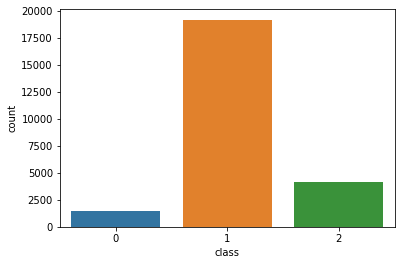

In [ ]:
# Class: 0 == hate_speech; 1 == offensive_language; 2 == neither
sns.countplot('class', data=df);
# Class are imbalanced

# Preprocessing

In [ ]:
# Reduction of the problem to a binary classification
type = []
for indice in range(len(df)):
  if df['class'][indice] == 2:
    type.append(0)
  else:
    type.append(1)
df['type'] = type

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


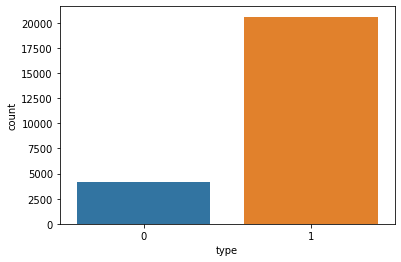

In [ ]:
# type: 0 == neither; 1 == hate_speech or offensive_language
sns.countplot('type', data=df);

In [ ]:
# replace '&amp' with 'and'
df['tweet'] = df['tweet'].str.replace('&amp','and')

In [ ]:
# check
df[df['tweet'].str.contains('&amp') == True]

,count,hate_speech,offensive_language,neither,class,tweet,type


## Split into train set and test set for classification

In [ ]:
x = df['tweet']
y = df['type']

## Solve imbalanced class
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size = 0.30, shuffle = False)
print('Lenght x_train: ', len(x_train))
print('Lenght y_train: ', len(y_train))
print(' Lenght x_test: ', len(x_test))
print(' Lenght y_test: ', len(y_test))

Lenght x_train:  17348
Lenght y_train:  17348
 Lenght x_test:  7435
 Lenght y_test:  7435


## Preprocessing functions

In [ ]:
STOPWORDS = stopwords.words('english')
STOPWORDS.remove('not')
STOPWORDS.remove('is')
STOPWORDS.remove('but')
# This words may be relevant for say if it is a hate speech / offensive language or not

In [ ]:
# Definition of useful function
def remove_urls(text):
    return re.sub(r'https?://\S+|www.\.\S+', '', text)

def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_numbers(text):
    return re.sub(r'\d+', '', text)

def remove_punctuation(text, punctuation=None):
    if punctuation is None:
        punctuation = string.punctuation
    return text.translate(str.maketrans(punctuation, ' '*len(punctuation)))

def remove_stopwords(text, stopwords=None):
    if stopwords is None:
        stopwords = STOPWORDS
    return ' '.join([word for word in text.split() if word not in stopwords])

def remove_extra_whitespace(text):
    return " ".join(text.split())

def remove_retweet(text):
  return re.sub("[RT]", '', text)

def remove_mention(text):
  return re.sub('@[\w\-]+', '', text)

def character_repeatation(text):
    Pattern_alpha = re.compile(r"([A-Za-z])\1{2,}", re.DOTALL)
    Formatted_text = Pattern_alpha.sub(r"\1\1", text) 
    Pattern_Punct = re.compile(r'([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}')
    Combined_Formatted = Pattern_Punct.sub(r'\1', Formatted_text)
    return Combined_Formatted

In [ ]:
# This function contains all the other functions without the last one
def preprocess_train(text):
  text = remove_emojis(text)
  text = remove_urls(text)
  text = remove_mention(text)
  text = remove_numbers(text)
  text = remove_punctuation(text, punctuation=None)
  text = remove_stopwords(text, STOPWORDS)
  # Remove words that are digits only
  text = re.sub('\b\d+\b', '', text)
  text = remove_retweet(text)
  text = remove_extra_whitespace(text)
  text = text.lower()
  return text

def preprocess_test(text):
  text = remove_punctuation(text, punctuation=None)
  return text

def preprocess_w2v(text):
  text = remove_emojis(text)
  text = remove_urls(text)
  text = remove_mention(text)
  text = remove_numbers(text)
  text = remove_punctuation(text, punctuation=None)
  # Remove words that are digits only
  text = re.sub('\b\d+\b', '', text)
  text = remove_retweet(text)
  text = remove_extra_whitespace(text)
  return text

def tokenization(text):
    tokens = re.split('\W+',text)
    return tokens

# defining the object for Lemmatization
wordnet_lemmatizer = WordNetLemmatizer()
# defining the function for lemmatization
def lemmatizer(text):
  lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
  return lemm_text

##### Save Dataframe for clustering

In [ ]:
df_clustering = df.copy()

In [ ]:
df_clustering['preprocessed'] = df_clustering.tweet.apply(lambda x: preprocess_train(x))
df_clustering['preprocessed'] = df_clustering.preprocessed.apply(lambda x: character_repeatation(x))

In [ ]:
print('Original preprocessed dataset: ', len(df_clustering))
# Remove nan values
nan = df_clustering[df_clustering['preprocessed'] == '']
df_clustering.drop(axis=0, index= nan.index, inplace=True)
print('Nan rows removed: ', len(nan), '; \nLenght dataset: ', len(df_clustering))

Original preprocessed dataset:  24783
Nan rows removed:  2 ; 
Lenght dataset:  24781


Delete empty row after preprocessing steps

In [ ]:
count = 0
indexes = []
for i in range(len(x_train)):
  if (x_train[i] == ''):
    indexes.append(i)
    count +=1
print(count)
indexes

0


[]

In [ ]:
print("Prima: ", len(x_train))
x_train = x_train.replace('', np.nan).dropna()
print("Dopo: ", len(x_train))

Prima:  17348
Dopo:  17348


In [ ]:
print("Prima: ", len(y_train))
y_train = y_train.drop(y_train.index[indexes])
print("Dopo: ", len(y_train))

Prima:  17348
Dopo:  17348


In [ ]:
x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [ ]:
x_train = x_train.apply(lambda x: preprocess_train(x))
x_test = x_test.apply(lambda x: preprocess_test(x))
x_train = x_train.apply(lambda x: character_repeatation(x))

#### Build and save Dataframe for word2vec classification

In [ ]:
df['preprocessed'] = df.tweet.apply(lambda x: preprocess_train(x))

In [ ]:
# Unigram
corpus = df['preprocessed'].values
 
# Creating the vectorizer
vectorizer = CountVectorizer(ngram_range=(1,1))
 
# Converting the text to numeric data
X = vectorizer.fit_transform(corpus)
 
#print(vectorizer.get_feature_names())
 
# Preparing Data frame For machine learning
# Priority column acts as a target variable and other columns as predictors
CountVectorizedData=pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
CountVectorizedData['type']=df['type']
print(CountVectorizedData.shape)
CountVectorizedData.head()

# Save Dataframe
CountVectorizedData_dd = from_pandas(CountVectorizedData, npartitions=1)
CountVectorizedData_dd.to_csv('/content/gdrive/MyDrive/Text Mining - PROGETTO/Dataset/CountVectorizedData_dd.csv', compression='gzip', 
                                index = False)

(24783, 20561)


['/content/gdrive/MyDrive/Text Mining - PROGETTO/Dataset/CountVectorizedData_dd.csv/0.part']

## Tokenization

In [ ]:
# train 
x_train = x_train.apply(lambda x: tokenization(x))
x_train


0        [as, woman, complain, cleaning, house, man, al...
1        [boy, dats, cold, tyga, dwn, bad, cuffin, dat,...
2        [dawg, you, ever, fuck, bitch, start, cry, you...
3                                     [look, like, tranny]
4        [he, shit, hear, might, true, might, faker, bi...
                               ...                        
17343                                  [hese, hoes, loyal]
17344    [i, finally, finished, work, i, going, chug, b...
17345    [some, hoes, live, jus, hit, clubs, every, wee...
17346    [bitches, say, nah, everything, i, cute, nah, ...
17347        [she, said, i, hurt, feelings, dating, dykes]
Name: tweet, Length: 17348, dtype: object

In [ ]:
# df clustering
df_clustering['tokenize'] = df_clustering.preprocessed.apply(lambda x: tokenization(x))

## Lemmatization

In [ ]:
x_train = x_train.apply(lambda x: lemmatizer(x))
x_train

0        [a, woman, complain, cleaning, house, man, alw...
1        [boy, dat, cold, tyga, dwn, bad, cuffin, dat, ...
2        [dawg, you, ever, fuck, bitch, start, cry, you...
3                                     [look, like, tranny]
4        [he, shit, hear, might, true, might, faker, bi...
                               ...                        
17343                                   [hese, hoe, loyal]
17344    [i, finally, finished, work, i, going, chug, b...
17345    [some, hoe, live, jus, hit, club, every, weekend]
17346    [bitch, say, nah, everything, i, cute, nah, ch...
17347          [she, said, i, hurt, feeling, dating, dyke]
Name: tweet, Length: 17348, dtype: object

In [ ]:
df_clustering['lemmatized'] = df_clustering.tokenize.apply(lambda x: lemmatizer(x))

In [ ]:
df_clustering[['preprocessed', 'tokenize', 'lemmatized']]

,preprocessed,tokenize,lemmatized
0,as woman complain cleaning house man always ta...,"[as, woman, complain, cleaning, house, man, al...","[a, woman, complain, cleaning, house, man, alw..."
1,boy dats cold tyga dwn bad cuffin dat hoe st p...,"[boy, dats, cold, tyga, dwn, bad, cuffin, dat,...","[boy, dat, cold, tyga, dwn, bad, cuffin, dat, ..."
2,dawg you ever fuck bitch start cry you confuse...,"[dawg, you, ever, fuck, bitch, start, cry, you...","[dawg, you, ever, fuck, bitch, start, cry, you..."
3,look like tranny,"[look, like, tranny]","[look, like, tranny]"
4,he shit hear might true might faker bitch told ya,"[he, shit, hear, might, true, might, faker, bi...","[he, shit, hear, might, true, might, faker, bi..."
...,...,...,...
24778,muthaf lie right his l is trash now mine bible...,"[muthaf, lie, right, his, l, is, trash, now, m...","[muthaf, lie, right, his, l, is, trash, now, m..."
24779,gone broke wrong heart baby drove redneck crazy,"[gone, broke, wrong, heart, baby, drove, redne...","[gone, broke, wrong, heart, baby, drove, redne..."
24780,young buck wanna eat dat nigguh like i aint fu...,"[young, buck, wanna, eat, dat, nigguh, like, i...","[young, buck, wanna, eat, dat, nigguh, like, i..."
24781,youu got wild bitches tellin lies,"[youu, got, wild, bitches, tellin, lies]","[youu, got, wild, bitch, tellin, lie]"


In [ ]:
df_clustering.to_csv('/content/gdrive/MyDrive/Text Mining - PROGETTO/Dataset/df_clustering.csv', index = False)

# Classification

In [ ]:
for i in range(len(x_train)):
  x_train[i] = " ".join(x_train[i])
x_train

0        a woman complain cleaning house man always tak...
1        boy dat cold tyga dwn bad cuffin dat hoe st place
2        dawg you ever fuck bitch start cry you confuse...
3                                         look like tranny
4        he shit hear might true might faker bitch told ya
                               ...                        
17343                                       hese hoe loyal
17344    i finally finished work i going chug bottle wi...
17345             some hoe live jus hit club every weekend
17346    bitch say nah everything i cute nah chillin wi...
17347                  she said i hurt feeling dating dyke
Name: tweet, Length: 17348, dtype: object

## Unigram

TF-IDF

In [ ]:
Tfidf_vect = TfidfVectorizer(ngram_range=(1,1), max_features=5000)
Tfidf_vect.fit(df['tweet'])
x_train_tfidf = Tfidf_vect.transform(x_train)
x_test_tfidf = Tfidf_vect.transform(x_test)

print(Tfidf_vect.vocabulary_)

{'rt': 3708, 'as': 487, 'woman': 4877, 'you': 4970, 'shouldn': 3875, 'complain': 1127, 'about': 306, 'cleaning': 1059, 'up': 4621, 'your': 4973, 'house': 2223, 'and': 421, 'man': 2821, 'should': 3873, 'always': 405, 'take': 4253, 'the': 4348, 'trash': 4498, 'out': 3278, 'boy': 765, 'dats': 1302, 'cold': 1096, 'tyga': 4583, 'bad': 559, 'for': 1811, 'cuffin': 1244, 'dat': 1298, 'hoe': 2169, 'in': 2320, '1st': 192, 'place': 3400, 'dawg': 1310, '80sbaby4life': 246, 'ever': 1606, 'fuck': 1865, 'bitch': 674, 'she': 3845, 'start': 4108, 'to': 4449, 'cry': 1231, 'be': 603, 'confused': 1138, 'shit': 3855, 'viva_based': 4677, 'look': 2753, 'like': 2681, 'tranny': 4496, 'hear': 2102, 'me': 2869, 'might': 2926, 'true': 4530, 'or': 3261, 'it': 2377, 'than': 4338, 'who': 4821, 'told': 4457, 'ya': 4928, 'just': 2479, 'blows': 709, 'claim': 1046, 'so': 3993, 'faithful': 1668, 'down': 1456, 'somebody': 4011, 'but': 865, 'still': 4142, 'fucking': 1870, 'with': 4867, 'hoes': 2170, '128514': 109, 'can': 8

In [ ]:
print(len(Tfidf_vect.vocabulary_))
print(Tfidf_vect.get_feature_names_out());

5000
['00' '000' '00sexilexi00' ... 'zoo' 'zooyorkinit' 'zzachbarness']


In [ ]:
print(x_train_tfidf)

  (0, 4877)	0.36020194839190856
  (0, 4498)	0.2270804928211908
  (0, 4253)	0.30196847867489063
  (0, 2821)	0.2692187336690184
  (0, 2223)	0.3470791522368431
  (0, 1127)	0.42932088167681776
  (0, 1059)	0.5080536260177215
  (0, 405)	0.3035234310761189
  (1, 4583)	0.3582462725951665
  (1, 4089)	0.36217220397098304
  (1, 3400)	0.31059744238708437
  (1, 2169)	0.16259798555795368
  (1, 1298)	0.4967526713140943
  (1, 1244)	0.3934468298689659
  (1, 1096)	0.3147020660665171
  (1, 765)	0.2644223949012178
  (1, 559)	0.2169373389117462
  (2, 4970)	0.3005866952982724
  (2, 4108)	0.357993410869691
  (2, 3855)	0.23397914171596584
  (2, 1865)	0.2285408643465873
  (2, 1606)	0.3232842575303464
  (2, 1310)	0.4275110222746002
  (2, 1231)	0.411407236470108
  (2, 1138)	0.4498369944324504
  :	:
  (17345, 4010)	0.2614917182116494
  (17345, 2711)	0.3846962545277697
  (17345, 2476)	0.3934844186061068
  (17345, 2169)	0.21602419371829218
  (17345, 2159)	0.3445235674381801
  (17345, 1607)	0.32805011448082155
  (17

Oversampling on train set

In [ ]:
over_sampler = SMOTE(k_neighbors=2)
x_train_smote, y_train_smote = over_sampler.fit_resample(x_train_tfidf, y_train)
print(f"Training target statistics: {Counter(y_train_smote)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0: 14422, 1: 14422})
Testing target statistics: Counter({1: 6198, 0: 1237})


### XGBOOST

In [ ]:
xgb_model=xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc' )

In [ ]:
xgb_model = xgb_model.fit(x_train_smote, y_train_smote)
xgb_predictions=xgb_model.predict(x_test_tfidf)
xgb_predicted_prob = xgb_model.predict_proba(x_test_tfidf)
print('Confusion Matrix: \n', confusion_matrix(y_test, xgb_predictions))
print()
print('XGBoost: \n', classification_report(y_test, xgb_predictions))

Confusion Matrix: 
 [[1179   58]
 [1860 4338]]

XGBoost: 
               precision    recall  f1-score   support

           0       0.39      0.95      0.55      1237
           1       0.99      0.70      0.82      6198

    accuracy                           0.74      7435
   macro avg       0.69      0.83      0.69      7435
weighted avg       0.89      0.74      0.77      7435



In [ ]:
print("XGBoost Accuracy Score -> ", accuracy_score(xgb_predictions, y_test)*100)

XGBoost Accuracy Score ->  74.20309347679893


ROC & Precision-Recall

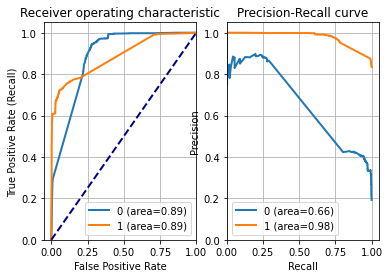

In [ ]:
## Plot roc
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

fig, ax = plt.subplots(nrows=1, ncols=2)
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           xgb_predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=2, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], xgb_predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=2, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()
# plt.savefig('XGBoost_ROC.png')

In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, xgb_model.predict_proba(x_test_tfidf)[:,1])
print('The AUC for XGBOOST is', auc)

The AUC for XGBOOST is 0.8855894135407072


### Naive Bayes

In [ ]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(x_train_smote, y_train_smote)
# predict the labels on validation dataset
NB_predictions = Naive.predict(x_test_tfidf)
NB_predicted_prob = Naive.predict_proba(x_test_tfidf)
# Confusion matrix
print('Confusion Matrix: \n', confusion_matrix(y_test, NB_predictions))
## Score
print()
print('Naive Bayes: \n', classification_report(y_test, NB_predictions))

Confusion Matrix: 
 [[1070  167]
 [ 998 5200]]

Naive Bayes: 
               precision    recall  f1-score   support

           0       0.52      0.86      0.65      1237
           1       0.97      0.84      0.90      6198

    accuracy                           0.84      7435
   macro avg       0.74      0.85      0.77      7435
weighted avg       0.89      0.84      0.86      7435



In [ ]:
print("Naive Bayes Accuracy Score -> ", accuracy_score(NB_predictions, y_test)*100)

Naive Bayes Accuracy Score ->  84.33086751849362


ROC & Precision-Recall

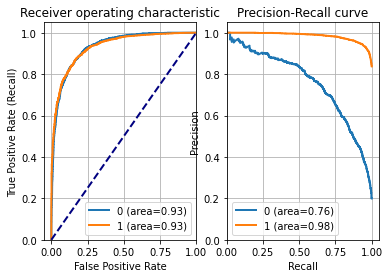

In [ ]:
## Plot roc
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

fig, ax = plt.subplots(nrows=1, ncols=2)
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           NB_predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=2, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], NB_predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=2, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()
# plt.savefig('NB_ROC.png')

In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, Naive.predict_proba(x_test_tfidf)[:,1])
print('The AUC for Naive Bayes is', auc)

The AUC for Naive Bayes is 0.9309906604028785


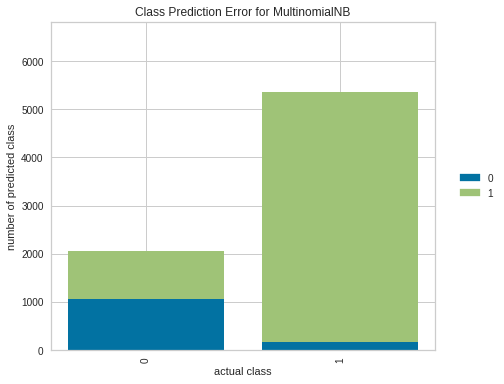

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import ClassPredictionError

Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(y_train)
Test_Y = Encoder.fit_transform(y_test)

# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(
    Naive, classes=Encoder.classes_
)

# Fit the training data to the visualizer
visualizer.fit(x_train_tfidf, Train_Y)

# Evaluate the model on the test data
visualizer.score(x_test_tfidf, Test_Y)

# Draw visualization
g = visualizer.poof()
# g.savefig('PredictionErrorHistogram.png')

### SVM

In [ ]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
from sklearn.svm import LinearSVC
#SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', probability = True)
SVM = LinearSVC()
SVM.fit(x_train_smote, y_train_smote)
# predict the labels on validation dataset
SVM_predictions = SVM.predict(x_test_tfidf)
SVM_predicted_prob = SVM._predict_proba_lr(x_test_tfidf)
# Confusion matrix
print('Confusion Matrix: \n', confusion_matrix(y_test, SVM_predictions))
## Score
print()
print('SVM: \n', classification_report(y_test, SVM_predictions))

Confusion Matrix: 
 [[1120  117]
 [1511 4687]]

SVM: 
               precision    recall  f1-score   support

           0       0.43      0.91      0.58      1237
           1       0.98      0.76      0.85      6198

    accuracy                           0.78      7435
   macro avg       0.70      0.83      0.72      7435
weighted avg       0.88      0.78      0.81      7435



In [ ]:
print("SVM Accuracy Score -> ", accuracy_score(SVM_predictions, y_test)*100)

SVM Accuracy Score ->  78.10356422326834


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


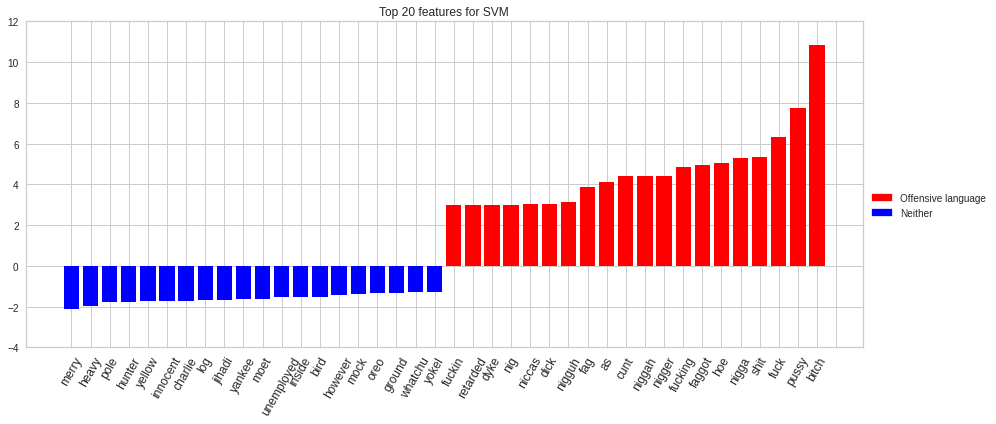

In [ ]:
def plot_coefficients(classifier, feature_names, top_features=20):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(15, 6))
 colors = ['blue' if c < 0 else 'red' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(0, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, fontsize=12)
 plt.ylim(-4, 12)
 colors = {'Offensive language':'red', 'Neither':'blue'}         
 labels = list(colors.keys())
 handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
 plt.legend(handles, labels, bbox_to_anchor=(1, 0.5))
 plt.title("Top 20 features for SVM")
 plt.show()

plot_coefficients(SVM, Tfidf_vect.get_feature_names());

ROC & Precision-Recall

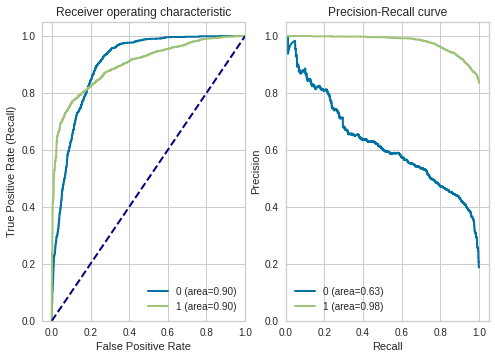

In [ ]:
## Plot roc
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

fig, ax = plt.subplots(nrows=1, ncols=2)
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           SVM_predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=2, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], SVM_predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=2, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()
# plt.savefig('SVM_ROC.png')

In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, SVM._predict_proba_lr(x_test_tfidf)[:,1])
print('The AUC for SVM is', auc)

The AUC for SVM is 0.900569863332449


Prediction Error

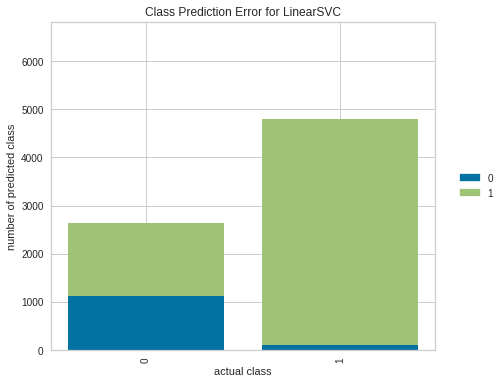

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import ClassPredictionError

Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(y_train)
Test_Y = Encoder.fit_transform(y_test)

# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(
    SVM, classes=Encoder.classes_
)

# Fit the training data to the visualizer
visualizer.fit(x_train_tfidf,Train_Y)

# Evaluate the model on the test data
visualizer.score(x_test_tfidf, Test_Y)

# Draw visualization
g = visualizer.poof()
# g.savefig('PredictionErrorHistogram.png')

## Bigram

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

Tfidf_vect = TfidfVectorizer(ngram_range=(1,2), max_features=5000)
Tfidf_vect.fit(df['tweet'])
x_train_tfidf = Tfidf_vect.transform(x_train)
x_test_tfidf = Tfidf_vect.transform(x_test)

print(Tfidf_vect.vocabulary_)

{'rt': 3519, 'as': 498, 'woman': 4794, 'you': 4871, 'shouldn': 3708, 'complain': 1162, 'about': 251, 'up': 4495, 'your': 4974, 'house': 2126, 'and': 382, 'man': 2697, 'should': 3703, 'always': 369, 'take': 3955, 'the': 4084, 'trash': 4406, 'out': 3206, 'complain about': 1163, 'up your': 4514, 'your house': 4982, 'you should': 4951, 'take the': 3959, 'the trash': 4170, 'boy': 915, 'dats': 1253, 'cold': 1138, 'tyga': 4470, 'bad': 578, 'for': 1615, 'dat': 1246, 'hoe': 2033, 'in': 2205, '1st': 169, 'place': 3291, 'bad for': 582, 'dat hoe': 1248, 'hoe in': 2045, 'in the': 2226, 'dawg': 1256, '80sbaby4life': 198, 'ever': 1475, 'fuck': 1672, 'bitch': 712, 'she': 3651, 'start': 3878, 'to': 4309, 'cry': 1210, 'be': 608, 'confused': 1166, 'shit': 3673, 'rt 80sbaby4life': 3520, 'you ever': 4899, 'fuck bitch': 1675, 'bitch and': 723, 'and she': 420, 'you be': 4884, 'as shit': 505, 'look': 2615, 'like': 2523, 'tranny': 4404, 'look like': 2618, 'hear': 1973, 'me': 2722, 'might': 2796, 'true': 4430, 

In [ ]:
print(len(Tfidf_vect.vocabulary_))
print(Tfidf_vect.get_feature_names_out());

5000
['000' '0221' '0221 24' ... 'zebra' 'zero' 'zone']


In [ ]:
print(x_train_tfidf)

  (0, 4794)	0.4181949490700287
  (0, 4406)	0.2636407591744391
  (0, 3955)	0.3505858119978917
  (0, 2697)	0.3125633137689653
  (0, 2126)	0.40295936499219626
  (0, 1162)	0.4984421240614525
  (0, 369)	0.3523911138379874
  (1, 4470)	0.36132916063197457
  (1, 3869)	0.36528887660737436
  (1, 3291)	0.31327028845038557
  (1, 2033)	0.16399722240375375
  (1, 1248)	0.3744210037625482
  (1, 1246)	0.501027476063779
  (1, 1138)	0.3174102344658897
  (1, 915)	0.26669788162715036
  (1, 578)	0.21880419302309034
  (2, 4899)	0.38172757889685066
  (2, 4871)	0.2516393822820905
  (2, 3878)	0.29969803115509164
  (2, 3673)	0.19587815298968678
  (2, 1675)	0.3917217631237905
  (2, 1672)	0.1913254406464104
  (2, 1475)	0.2706408904284201
  (2, 1256)	0.3578954466271872
  (2, 1210)	0.3444139892785033
  :	:
  (17345, 2580)	0.34587777600402897
  (17345, 2383)	0.35377915432731155
  (17345, 2033)	0.19422587770724664
  (17345, 2024)	0.30975878731330336
  (17345, 1477)	0.29494761822876825
  (17345, 1132)	0.368719776993679

In [ ]:
from imblearn.over_sampling import SMOTE
over_sampler = SMOTE(k_neighbors=2)
x_train_smote, y_train_smote = over_sampler.fit_resample(x_train_tfidf, y_train)
print(f"Training target statistics: {Counter(y_train_smote)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0: 14422, 1: 14422})
Testing target statistics: Counter({1: 6198, 0: 1237})


### XGBOOST

In [ ]:
xgb_model=xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc' )

In [ ]:
xgb_model = xgb_model.fit(x_train_smote, y_train_smote)
xgb_predictions=xgb_model.predict(x_test_tfidf)
xgb_predicted_prob = xgb_model.predict_proba(x_test_tfidf)
print('Confusion Matrix: \n', confusion_matrix(y_test, xgb_predictions))
print()
print('XGBoost: \n', classification_report(y_test, xgb_predictions))

Confusion Matrix: 
 [[1184   53]
 [1951 4247]]

XGBoost: 
               precision    recall  f1-score   support

           0       0.38      0.96      0.54      1237
           1       0.99      0.69      0.81      6198

    accuracy                           0.73      7435
   macro avg       0.68      0.82      0.68      7435
weighted avg       0.89      0.73      0.76      7435



In [ ]:
print("XGBoost Accuracy Score -> ", accuracy_score(xgb_predictions, y_test)*100)

XGBoost Accuracy Score ->  73.04640215198386


ROC & Precision-Recall

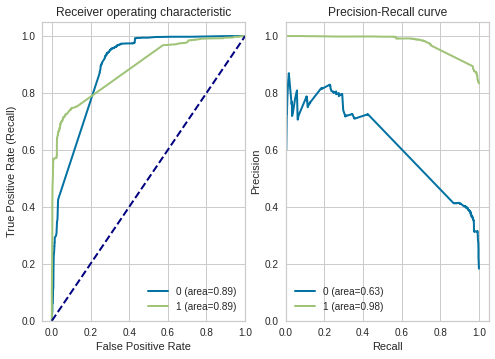

In [ ]:
## Plot roc
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

fig, ax = plt.subplots(nrows=1, ncols=2)
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           xgb_predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=2, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], xgb_predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=2, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()
# plt.savefig('XGBoost_ROC.png')

In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, xgb_model.predict_proba(x_test_tfidf)[:,1])
print('The AUC for XGBOOST is', auc)

The AUC for XGBOOST is 0.8904400538103538


### Naive Bayes

In [ ]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(x_train_smote, y_train_smote)
# predict the labels on validation dataset
NB_predictions = Naive.predict(x_test_tfidf)
NB_predicted_prob = Naive.predict_proba(x_test_tfidf)
# Confusion matrix
print('Confusion Matrix: \n', confusion_matrix(y_test, NB_predictions))
## Score
print()
print('Naive Bayes: \n', classification_report(y_test, NB_predictions))

Confusion Matrix: 
 [[1149   88]
 [1770 4428]]

Naive Bayes: 
               precision    recall  f1-score   support

           0       0.39      0.93      0.55      1237
           1       0.98      0.71      0.83      6198

    accuracy                           0.75      7435
   macro avg       0.69      0.82      0.69      7435
weighted avg       0.88      0.75      0.78      7435



In [ ]:
print("Naive Bayes Accuracy Score -> ", accuracy_score(NB_predictions, y_test)*100)

Naive Bayes Accuracy Score ->  75.01008742434432


ROC & Precision-Recall

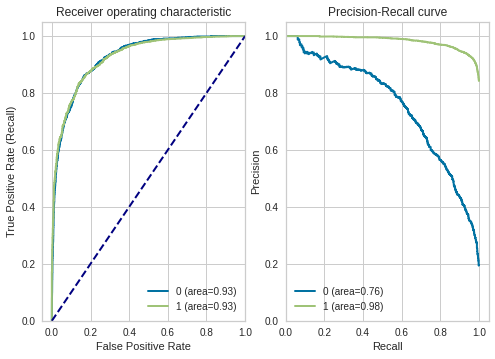

In [ ]:
## Plot roc
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

fig, ax = plt.subplots(nrows=1, ncols=2)
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           NB_predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=2, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], NB_predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=2, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()
# plt.savefig('NB_ROC.png')

In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, Naive.predict_proba(x_test_tfidf)[:,1])
print('The AUC for Naive Bayes is', auc)

The AUC for Naive Bayes is 0.9251229241028281


### SVM

In [ ]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
from sklearn.svm import LinearSVC
#SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', probability = True)
SVM = LinearSVC()
SVM.fit(x_train_smote, y_train_smote)
# predict the labels on validation dataset
SVM_predictions = SVM.predict(x_test_tfidf)
SVM_predicted_prob = SVM._predict_proba_lr(x_test_tfidf)
# Confusion matrix
print('Confusion Matrix: \n', confusion_matrix(y_test, SVM_predictions))
## Score
print()
print('SVM: \n', classification_report(y_test, SVM_predictions))

Confusion Matrix: 
 [[1149   88]
 [1840 4358]]

SVM: 
               precision    recall  f1-score   support

           0       0.38      0.93      0.54      1237
           1       0.98      0.70      0.82      6198

    accuracy                           0.74      7435
   macro avg       0.68      0.82      0.68      7435
weighted avg       0.88      0.74      0.77      7435



In [ ]:
print("SVM Accuracy Score -> ", accuracy_score(SVM_predictions, y_test)*100)

SVM Accuracy Score ->  74.06859448554137


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


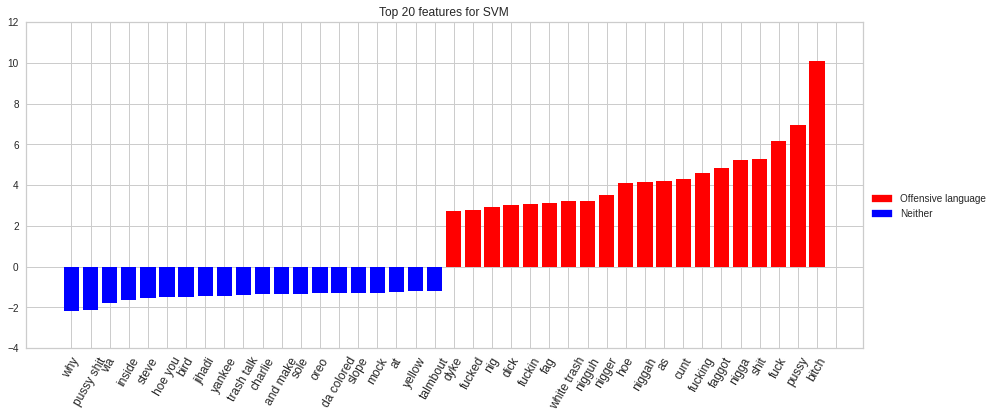

In [ ]:
def plot_coefficients(classifier, feature_names, top_features=20):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(15, 6))
 colors = ['blue' if c < 0 else 'red' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(0, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, fontsize=12)
 plt.ylim(-4, 12)
 colors = {'Offensive language':'red', 'Neither':'blue'}         
 labels = list(colors.keys())
 handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
 plt.legend(handles, labels, bbox_to_anchor=(1, 0.5))
 plt.title("Top 20 features for SVM")
 plt.show()

plot_coefficients(SVM, Tfidf_vect.get_feature_names());

ROC & Precision-Recall

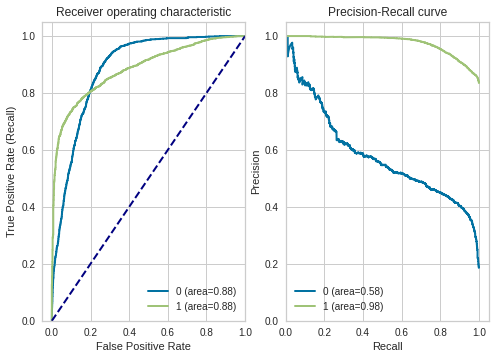

In [ ]:
## Plot roc
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

fig, ax = plt.subplots(nrows=1, ncols=2)
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           SVM_predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=2, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], SVM_predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=2, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()
# plt.savefig('SVM_ROC.png')

In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, SVM._predict_proba_lr(x_test_tfidf)[:,1])
print('The AUC for SVM is', auc)

The AUC for SVM is 0.884740898764381


Prediction Error

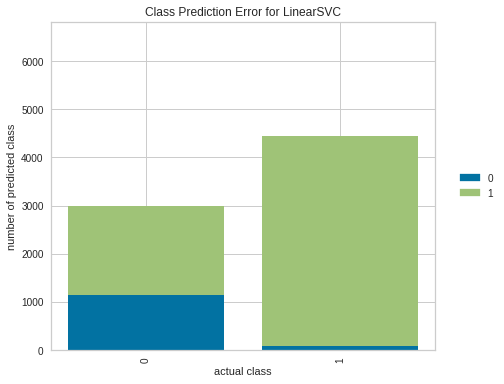

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import ClassPredictionError

Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(y_train)
Test_Y = Encoder.fit_transform(y_test)

# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(
    SVM, classes=Encoder.classes_
)

# Fit the training data to the visualizer
visualizer.fit(x_train_tfidf,Train_Y)

# Evaluate the model on the test data
visualizer.score(x_test_tfidf, Test_Y)

# Draw visualization
g = visualizer.poof()
# g.savefig('PredictionErrorHistogram.png')

## Trigram

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

Tfidf_vect = TfidfVectorizer(ngram_range=(1,3), max_features=5000)
Tfidf_vect.fit(df['tweet'])
x_train_tfidf = Tfidf_vect.transform(x_train)
x_test_tfidf = Tfidf_vect.transform(x_test)

print(Tfidf_vect.vocabulary_)

{'rt': 3503, 'as': 531, 'woman': 4775, 'you': 4851, 'shouldn': 3678, 'complain': 1178, 'about': 289, 'up': 4477, 'your': 4974, 'house': 2121, 'and': 424, 'man': 2692, 'should': 3673, 'always': 412, 'take': 3928, 'the': 4049, 'trash': 4393, 'out': 3192, 'complain about': 1179, 'up your': 4496, 'your house': 4983, 'you should': 4950, 'take the': 3932, 'the trash': 4144, 'boy': 942, 'dats': 1261, 'cold': 1158, 'tyga': 4455, 'bad': 611, 'for': 1609, 'dat': 1254, 'hoe': 2022, 'in': 2207, '1st': 203, 'place': 3278, 'bad for': 615, 'dat hoe': 1256, 'hoe in': 2037, 'in the': 2232, 'dawg': 1263, '80sbaby4life': 230, 'ever': 1472, 'fuck': 1665, 'bitch': 730, 'she': 3621, 'start': 3850, 'to': 4291, 'cry': 1223, 'be': 641, 'confused': 1182, 'shit': 3641, 'rt 80sbaby4life': 3504, 'you ever': 4882, 'fuck bitch': 1668, 'bitch and': 741, 'and she': 457, 'you be': 4864, 'as shit': 537, 'bitch and she': 742, 'look': 2607, 'like': 2519, 'tranny': 4391, 'look like': 2612, 'hear': 1968, 'me': 2717, 'might'

In [ ]:
print(len(Tfidf_vect.vocabulary_))
print(Tfidf_vect.get_feature_names_out());

5000
['000' '0221' '0221 24' ... 'zebra' 'zero' 'zone']


In [ ]:
print(x_train_tfidf)

  (0, 4775)	0.4181949490700287
  (0, 4393)	0.2636407591744391
  (0, 3928)	0.3505858119978917
  (0, 2692)	0.3125633137689653
  (0, 2121)	0.40295936499219626
  (0, 1178)	0.4984421240614525
  (0, 412)	0.3523911138379874
  (1, 4455)	0.36132916063197457
  (1, 3842)	0.36528887660737436
  (1, 3278)	0.31327028845038557
  (1, 2022)	0.16399722240375375
  (1, 1256)	0.3744210037625482
  (1, 1254)	0.501027476063779
  (1, 1158)	0.3174102344658897
  (1, 942)	0.26669788162715036
  (1, 611)	0.21880419302309034
  (2, 4882)	0.38172757889685066
  (2, 4851)	0.2516393822820905
  (2, 3850)	0.29969803115509164
  (2, 3641)	0.19587815298968678
  (2, 1668)	0.3917217631237905
  (2, 1665)	0.1913254406464104
  (2, 1472)	0.2706408904284201
  (2, 1263)	0.3578954466271872
  (2, 1223)	0.3444139892785033
  :	:
  (17345, 2573)	0.34587777600402897
  (17345, 2384)	0.35377915432731155
  (17345, 2022)	0.19422587770724664
  (17345, 2012)	0.30975878731330336
  (17345, 1474)	0.29494761822876825
  (17345, 1152)	0.368719776993679

In [ ]:
from imblearn.over_sampling import SMOTE
over_sampler = SMOTE(k_neighbors=2)
x_train_smote, y_train_smote = over_sampler.fit_resample(x_train_tfidf, y_train)
print(f"Training target statistics: {Counter(y_train_smote)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0: 14422, 1: 14422})
Testing target statistics: Counter({1: 6198, 0: 1237})


### XGBOOST

In [ ]:
xgb_model=xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc' )

In [ ]:
xgb_model = xgb_model.fit(x_train_smote, y_train_smote)
xgb_predictions=xgb_model.predict(x_test_tfidf)
xgb_predicted_prob = xgb_model.predict_proba(x_test_tfidf)
print('Confusion Matrix: \n', confusion_matrix(y_test, xgb_predictions))
print()
print('XGBoost: \n', classification_report(y_test, xgb_predictions))

Confusion Matrix: 
 [[1184   53]
 [1923 4275]]

XGBoost: 
               precision    recall  f1-score   support

           0       0.38      0.96      0.55      1237
           1       0.99      0.69      0.81      6198

    accuracy                           0.73      7435
   macro avg       0.68      0.82      0.68      7435
weighted avg       0.89      0.73      0.77      7435



In [ ]:
print("XGBoost Accuracy Score -> ", accuracy_score(xgb_predictions, y_test)*100)

XGBoost Accuracy Score ->  73.42299932750504


ROC & Precision-Recall

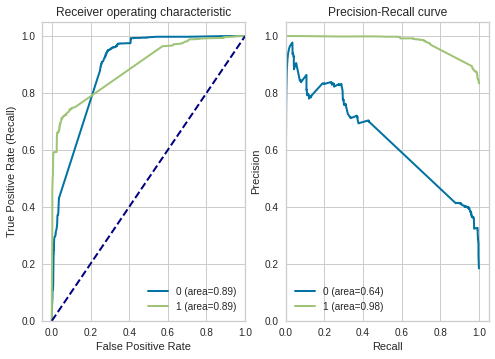

In [ ]:
## Plot roc
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

fig, ax = plt.subplots(nrows=1, ncols=2)
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           xgb_predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=2, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], xgb_predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=2, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()
# plt.savefig('XGBoost_ROC.png')

In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, xgb_model.predict_proba(x_test_tfidf)[:,1])
print('The AUC for XGBOOST is', auc)

The AUC for XGBOOST is 0.8916209703863059


### Naive Bayes

In [ ]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(x_train_smote, y_train_smote)
# predict the labels on validation dataset
NB_predictions = Naive.predict(x_test_tfidf)
NB_predicted_prob = Naive.predict_proba(x_test_tfidf)
# Confusion matrix
print('Confusion Matrix: \n', confusion_matrix(y_test, NB_predictions))
## Score
print()
print('Naive Bayes: \n', classification_report(y_test, NB_predictions))

Confusion Matrix: 
 [[1146   91]
 [1774 4424]]

Naive Bayes: 
               precision    recall  f1-score   support

           0       0.39      0.93      0.55      1237
           1       0.98      0.71      0.83      6198

    accuracy                           0.75      7435
   macro avg       0.69      0.82      0.69      7435
weighted avg       0.88      0.75      0.78      7435



In [ ]:
print("Naive Bayes Accuracy Score -> ", accuracy_score(NB_predictions, y_test)*100)

Naive Bayes Accuracy Score ->  74.91593813046403


ROC & Precision-Recall

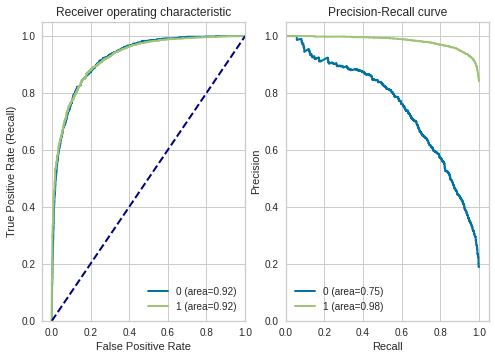

In [ ]:
## Plot roc
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

fig, ax = plt.subplots(nrows=1, ncols=2)
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           NB_predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=2, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], NB_predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=2, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()
# plt.savefig('NB_ROC.png')

In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, Naive.predict_proba(x_test_tfidf)[:,1])
print('The AUC for Naive Bayes is', auc)

The AUC for Naive Bayes is 0.9243741233448712


### SVM

In [ ]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
from sklearn.svm import LinearSVC
#SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', probability = True)
SVM = LinearSVC()
SVM.fit(x_train_smote, y_train_smote)
# predict the labels on validation dataset
SVM_predictions = SVM.predict(x_test_tfidf)
SVM_predicted_prob = SVM._predict_proba_lr(x_test_tfidf)
# Confusion matrix
print('Confusion Matrix: \n', confusion_matrix(y_test, SVM_predictions))
## Score
print()
print('SVM: \n', classification_report(y_test, SVM_predictions))

Confusion Matrix: 
 [[1165   72]
 [1912 4286]]

SVM: 
               precision    recall  f1-score   support

           0       0.38      0.94      0.54      1237
           1       0.98      0.69      0.81      6198

    accuracy                           0.73      7435
   macro avg       0.68      0.82      0.68      7435
weighted avg       0.88      0.73      0.77      7435



In [ ]:
print("SVM Accuracy Score -> ", accuracy_score(SVM_predictions, y_test)*100)

SVM Accuracy Score ->  73.31540013449899


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


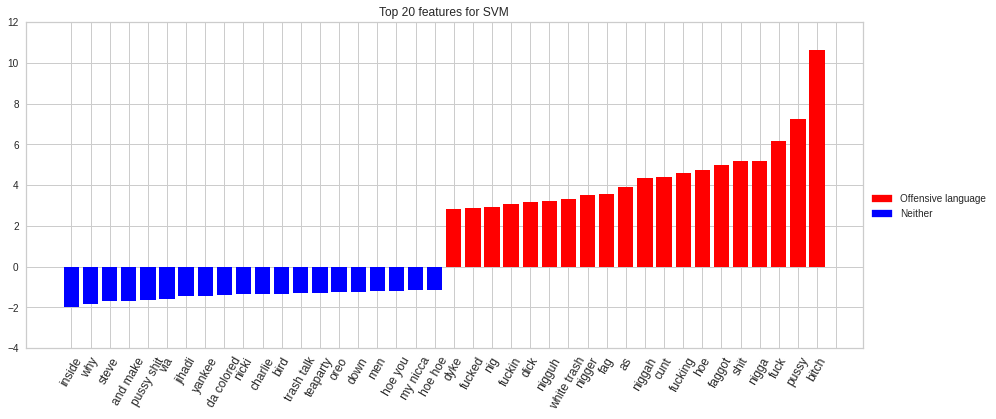

In [ ]:
def plot_coefficients(classifier, feature_names, top_features=20):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(15, 6))
 colors = ['blue' if c < 0 else 'red' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(0, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, fontsize=12)
 plt.ylim(-4, 12)
 colors = {'Offensive language':'red', 'Neither':'blue'}         
 labels = list(colors.keys())
 handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
 plt.legend(handles, labels, bbox_to_anchor=(1, 0.5))
 plt.title("Top 20 features for SVM")
 plt.show()

plot_coefficients(SVM, Tfidf_vect.get_feature_names());

ROC & Precision-Recall

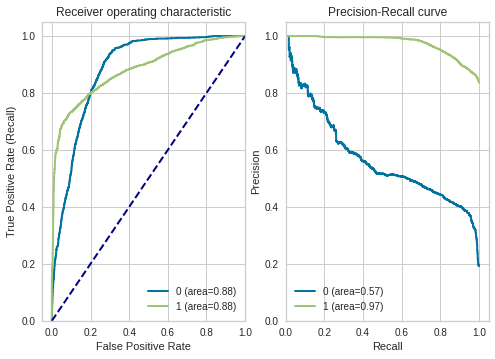

In [ ]:
## Plot roc
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

fig, ax = plt.subplots(nrows=1, ncols=2)
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           SVM_predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=2, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], SVM_predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=2, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()
# plt.savefig('SVM_ROC.png')

In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, SVM._predict_proba_lr(x_test_tfidf)[:,1])
print('The AUC for SVM is', auc)

The AUC for SVM is 0.881512355799443


Prediction Error

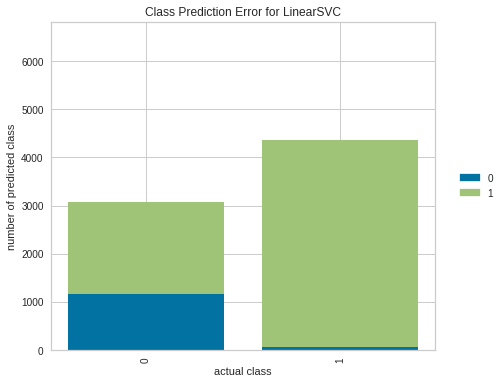

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import ClassPredictionError

Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(y_train)
Test_Y = Encoder.fit_transform(y_test)

# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(
    SVM, classes=Encoder.classes_
)

# Fit the training data to the visualizer
visualizer.fit(x_train_tfidf,Train_Y)

# Evaluate the model on the test data
visualizer.score(x_test_tfidf, Test_Y)

# Draw visualization
g = visualizer.poof()
# g.savefig('PredictionErrorHistogram.png')

## Word2Vec

### Download google word2vec

In [ ]:
#Loading the word vectors from Google trained word2Vec model
GoogleModel = gensim.models.KeyedVectors.load_word2vec_format('/content/gdrive/MyDrive/Text Mining - PROGETTO/GoogleNews-vectors-negative300.bin.gz', binary=True,)

In [ ]:
CountVectorizedData = dd.read_csv('/content/gdrive/MyDrive/Text Mining - PROGETTO/Dataset/CountVectorizedData_dd.csv/0.part', 
                     compression = 'gzip', sample=1000000)

/usr/local/lib/python3.8/dist-packages/dask/dataframe/io/csv.py:529: UserWarning: Warning gzip compression does not support breaking apart files
Please ensure that each individual file can fit in memory and
use the keyword ``blocksize=None to remove this message``
Setting ``blocksize=None``
  warn(


In [ ]:
# Creating the list of words which are present in the Document term matrix
WordsVocab=CountVectorizedData.columns

In [ ]:
# Defining a function which takes text input and returns one vector for each sentence
def FunctionText2Vec(inpTextData, vectorizer, WordsVocab):
    # Converting the text to numeric data
    X = vectorizer.fit_transform(inpTextData)
    CountVecData=pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
    print(CountVecData.shape, CountVecData.columns[0], CountVecData.columns[-1])
    # Creating empty dataframe to hold sentences
    W2Vec_Data=pd.DataFrame()
    
    # Looping through each row for the data
    for i in range(CountVecData.shape[0]):
 
        # initiating a sentence with all zeros
        Sentence = np.zeros(300)
 
        # Looping thru each word in the sentence and if its present in 
        # the Word2Vec model then storing its vector
        for word in WordsVocab[CountVecData.iloc[i , :]>=1]:
            #print(word)
            if word in GoogleModel.key_to_index.keys():    
                Sentence=Sentence+GoogleModel[word]
        # Appending the sentence to the dataframe
        W2Vec_Data=W2Vec_Data.append(pd.DataFrame([Sentence]))
    return(W2Vec_Data)

## Fit GoogleModel to Unigram 

In [ ]:
# Creating the vectorizer
vectorizer = CountVectorizer(ngram_range=(1,1))
 
# Converting the text to numeric data
X = vectorizer.fit_transform(df['preprocessed'])

y = df['type']

In [ ]:
# Calling the function to convert all the text data to Word2Vec Vectors
W2Vec_Data=FunctionText2Vec(df['preprocessed'], CountVectorizer(ngram_range=(1,1)), WordsVocab)

# Adding the target variable
W2Vec_Data.reset_index(inplace=True, drop=True)
W2Vec_Data['type']=CountVectorizedData['type']

# Assigning to DataForML variable
DataForML=W2Vec_Data

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
# On this data Min Max Normalization is used because we need to fit Naive Bayes
 
# Choose between standardization and MinMAx normalization
PredictorScaler=MaxAbsScaler()
 
# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)
 
# Generating the standardized values of X
X=PredictorScalerFit.transform(X)
 
# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train_imbalanced, X_test_imbalanced, y_train_imbalanced, y_test_imbalanced = train_test_split(X, y, random_state=42, test_size = 0.30, shuffle = False)
 
# Sanity check for the sampled data
print(X_train_imbalanced.shape)
print(y_train_imbalanced.shape)
print(X_test_imbalanced.shape)
print(y_test_imbalanced.shape)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(24783, 20561) aa zzzzzz
(17348, 20561)
(17348,)
(7435, 20561)
(7435,)


In [ ]:
over_sampler = SMOTE(k_neighbors=2)
X_train, y_train = over_sampler.fit_resample(X_train_imbalanced, y_train_imbalanced)
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test_imbalanced)}")

Training target statistics: Counter({0: 14422, 1: 14422})
Testing target statistics: Counter({1: 6198, 0: 1237})


## Models: Unigram

### XGBOOST

In [ ]:
xgb_model=xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc' )

In [ ]:
xgb_model = xgb_model.fit(X_train, y_train)
xgb_predictions=xgb_model.predict(X_test_imbalanced)
xgb_predicted_prob = xgb_model.predict_proba(X_test_imbalanced)
print('Confusion Matrix: \n', confusion_matrix(y_test_imbalanced, xgb_predictions))
print()
print('XGBoost: \n', classification_report(y_test_imbalanced, xgb_predictions))

Confusion Matrix: 
 [[1208   29]
 [ 374 5824]]

XGBoost: 
               precision    recall  f1-score   support

           0       0.76      0.98      0.86      1237
           1       1.00      0.94      0.97      6198

    accuracy                           0.95      7435
   macro avg       0.88      0.96      0.91      7435
weighted avg       0.96      0.95      0.95      7435



In [ ]:
print("XGBoost Accuracy Score -> ", accuracy_score(xgb_predictions, y_test_imbalanced)*100)

XGBoost Accuracy Score ->  94.5796906523201


ROC & Precision-Recall

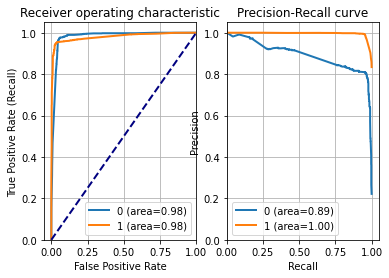

In [ ]:
## Plot roc
classes = np.unique(y_test_imbalanced)
y_test_array = pd.get_dummies(y_test_imbalanced, drop_first=False).values

fig, ax = plt.subplots(nrows=1, ncols=2)
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           xgb_predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=2, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], xgb_predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=2, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

plt.tight_layout()
# plt.savefig('XGBoost_ROC.png')

In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test_imbalanced, xgb_model.predict_proba(X_test_imbalanced)[:,1])
print('The AUC for XGBOOST is', auc)

The AUC for XGBOOST is 0.9802173648213118


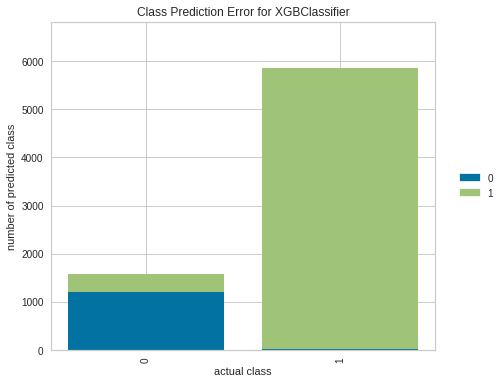

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import ClassPredictionError

Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(y_train)
Test_Y = Encoder.fit_transform(y_test_imbalanced)

# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(
    xgb_model, classes=Encoder.classes_
)

# Fit the training data to the visualizer
visualizer.fit(X_train, Train_Y)

# Evaluate the model on the test data
visualizer.score(X_test_imbalanced, Test_Y)

# Draw visualization
g = visualizer.poof()
# g.savefig('PredictionErrorHistogram.png')

### Naive Bayes

In [ ]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(X_train, y_train)
# predict the labels on validation dataset
NB_predictions = Naive.predict(X_test_imbalanced)
NB_predicted_prob = Naive.predict_proba(X_test_imbalanced)
# Confusion matrix
print('Confusion Matrix: \n', confusion_matrix(y_test_imbalanced, NB_predictions))
## Score
print()
print('Naive Bayes: \n', classification_report(y_test_imbalanced, NB_predictions))

Confusion Matrix: 
 [[ 922  315]
 [ 394 5804]]

Naive Bayes: 
               precision    recall  f1-score   support

           0       0.70      0.75      0.72      1237
           1       0.95      0.94      0.94      6198

    accuracy                           0.90      7435
   macro avg       0.82      0.84      0.83      7435
weighted avg       0.91      0.90      0.91      7435



In [ ]:
print("Naive Bayes Accuracy Score -> ", accuracy_score(NB_predictions, y_test_imbalanced)*100)

Naive Bayes Accuracy Score ->  90.4640215198386


ROC & Precision-Recall

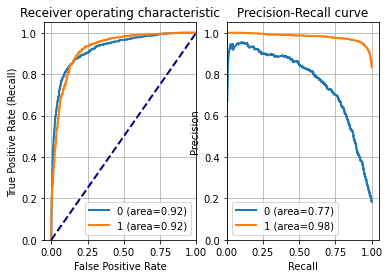

In [ ]:
## Plot roc
classes = np.unique(y_test_imbalanced)
y_test_array = pd.get_dummies(y_test_imbalanced, drop_first=False).values

fig, ax = plt.subplots(nrows=1, ncols=2)
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           NB_predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=2, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], NB_predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=2, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()
# plt.savefig('NB_ROC.png')

In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test_imbalanced, Naive.predict_proba(X_test_imbalanced)[:,1])
print('The AUC for Naive Bayes is', auc)

The AUC for Naive Bayes is 0.9248180431114111


### SVM

In [ ]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
from sklearn.svm import LinearSVC
#SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', probability = True)
SVM = LinearSVC()
SVM.fit(X_train, y_train)
# predict the labels on validation dataset
SVM_predictions = SVM.predict(X_test_imbalanced)
SVM_predicted_prob = SVM._predict_proba_lr(X_test_imbalanced)
# Confusion matrix
print('Confusion Matrix: \n', confusion_matrix(y_test_imbalanced, SVM_predictions))
## Score
print()
print('SVM: \n', classification_report(y_test_imbalanced, SVM_predictions))

Confusion Matrix: 
 [[1089  148]
 [ 252 5946]]

SVM: 
               precision    recall  f1-score   support

           0       0.81      0.88      0.84      1237
           1       0.98      0.96      0.97      6198

    accuracy                           0.95      7435
   macro avg       0.89      0.92      0.91      7435
weighted avg       0.95      0.95      0.95      7435



In [ ]:
print("SVM Accuracy Score -> ", accuracy_score(SVM_predictions, y_test_imbalanced)*100)

SVM Accuracy Score ->  94.62004034969738


ROC & Precision-Recall

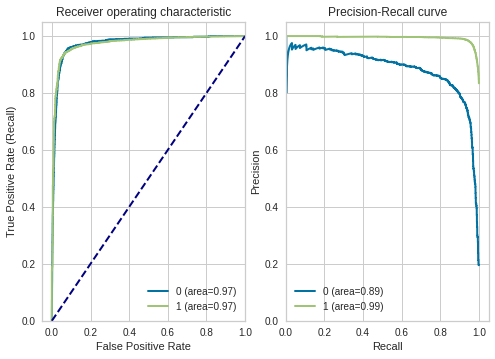

In [ ]:
## Plot roc
classes = np.unique(y_test_imbalanced)
y_test_array = pd.get_dummies(y_test_imbalanced, drop_first=False).values

fig, ax = plt.subplots(nrows=1, ncols=2)
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           SVM_predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=2, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], SVM_predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=2, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()
# plt.savefig('SVM_ROC.png')

In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test_imbalanced, SVM._predict_proba_lr(X_test_imbalanced)[:,1])
print('The AUC for Naive Bayes is', auc)

The AUC for Naive Bayes is 0.9743109559163607


Prediction Error

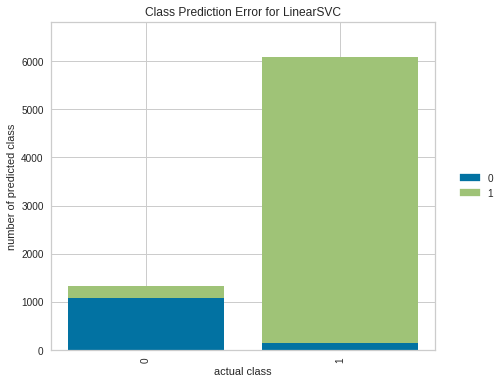

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import ClassPredictionError

Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(y_train)
Test_Y = Encoder.fit_transform(y_test_imbalanced)

# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(
    SVM, classes=Encoder.classes_
)

# Fit the training data to the visualizer
visualizer.fit(X_train,Train_Y)

# Evaluate the model on the test data
visualizer.score(X_test_imbalanced, Test_Y)

# Draw visualization
g = visualizer.poof()
# g.savefig('PredictionErrorHistogram.png')

In [ ]:
# df = pd.read_csv(dataset)[['type', 'preprocessed']].rename(columns={'preprocessed': 'text'})
df = pd.read_csv(dataset)[['type', 'preprocessed', 'tokenize', 'stemmed', 'lemmatized']].rename(columns={'preprocessed': 'text'})
df['tokenize'] = df['tokenize'].apply(literal_eval)
df['stemmed'] = df['stemmed'].apply(literal_eval)
df['lemmatized'] = df['lemmatized'].apply(literal_eval)
df.head(2)

,type,text,tokenize,stemmed,lemmatized
0,0,as woman complain cleaning house man always t...,"[as, woman, complain, cleaning, house, man, al...","[as, woman, complain, clean, hous, man, alway,...","[a, woman, complain, cleaning, house, man, alw..."
1,1,boy dats cold tyga dwn bad cuffin dat hoe st p...,"[boy, dats, cold, tyga, dwn, bad, cuffin, dat,...","[boy, dat, cold, tyga, dwn, bad, cuffin, dat, ...","[boy, dat, cold, tyga, dwn, bad, cuffin, dat, ..."


Clustering

# Clustering

In [47]:
# %%capture
# !pip install gensim==3.6.0

### Import dataset

In [48]:
dt = pd.read_csv('/content/gdrive/MyDrive/Text Mining - PROGETTO/Dataset/df_clustering.csv')
dt['lemmatized'] = dt['lemmatized'].apply(literal_eval)
dt.head(2)

,count,hate_speech,offensive_language,neither,class,tweet,type,preprocessed,tokenize,lemmatized
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,0,as woman complain cleaning house man always ta...,"['as', 'woman', 'complain', 'cleaning', 'house...","[a, woman, complain, cleaning, house, man, alw..."
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1,boy dats cold tyga dwn bad cuffin dat hoe st p...,"['boy', 'dats', 'cold', 'tyga', 'dwn', 'bad', ...","[boy, dat, cold, tyga, dwn, bad, cuffin, dat, ..."


In [49]:
# Sampling: preserve original proportion
print('Original Proportion: ')
print((dt['type'].value_counts()) / len(dt) * 100, 'Len:', len(dt))
df = dt.groupby('type', group_keys=False).apply(lambda x: x.sample(frac=0.2))
print('Sample Proportion: ')
print((df['type'].value_counts()) / len(df) * 100, 'Len:', len(df))


Original Proportion: 
1    83.204875
0    16.795125
Name: type, dtype: float64 Len: 24781
Sample Proportion: 
1    83.212268
0    16.787732
Name: type, dtype: float64 Len: 4956


### Generate uni-gram, bi-gram, tri-gram

In [50]:
# method to generate n-grams:
import nltk
nltk.download('punkt')
from nltk.util import ngrams

def extract_ngrams(data, num):
  # n_grams = ngrams(nltk.word_tokenize(data), num)
  n_grams = ngrams(data, num)
  gram_list = [ ' '.join(grams) for grams in n_grams]
  return gram_list

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [51]:
## Make uni-gram
corpus = list(df['lemmatized'])
print('Uni-gram', corpus[0])

## Make bi-gram
corpus_bigrams = list(df['lemmatized'].apply(lambda z: extract_ngrams(z, 2))) + corpus
print('Bi-gram', corpus_bigrams[0])

## Make bi-gram
corpus_trigrams = list(df['lemmatized'].apply(lambda z: extract_ngrams(z, 3))) + corpus_bigrams
print('Tri-gram', corpus_trigrams[0])


Uni-gram ['charlie', 'brown', 'a', 'christmas', 'story', 'udolph', 'but', 'island', 'misfit', 'toy']
Bi-gram ['charlie brown', 'brown a', 'a christmas', 'christmas story', 'story udolph', 'udolph but', 'but island', 'island misfit', 'misfit toy']
Tri-gram ['charlie brown a', 'brown a christmas', 'a christmas story', 'christmas story udolph', 'story udolph but', 'udolph but island', 'but island misfit', 'island misfit toy']


# Word2Vec: size = 300; alpha = 0.03

##### Set parameters of Word2Vec

*   min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)ce elenco
*   window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)
*   size = int - Dimensionality of the feature vectors. - (50, 300)
*   sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
*   alpha = float - The initial learning rate - (0.01, 0.05)
*   min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
*   negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
*   workers = int - Use these many worker threads to train the model (=faster training with multicore machines







In [52]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [53]:
w2v_model_unigram = Word2Vec(
                        corpus,
                        min_count=2,
                        window=2,
                        size=300,
                        sample=6e-5, 
                        alpha=0.03, 
                        min_alpha=0.0007, 
                        negative=20,
                        workers=8
                     )

w2v_model_bigram = Word2Vec(
                        corpus_bigrams,
                        min_count=2,
                        window=2,
                        size=300,
                        sample=6e-5, 
                        alpha=0.03, 
                        min_alpha=0.0007, 
                        negative=20,
                        workers=8
                     )

w2v_model_trigram = Word2Vec(
                        corpus_trigrams,
                        min_count=2,
                        window=2,
                        size=300,
                        sample=6e-5, 
                        alpha=0.03, 
                        min_alpha=0.0007, 
                        negative=20,
                        workers=8
                     )

In [54]:
X_unigram = w2v_model_unigram[w2v_model_unigram.wv.vocab]
X_bigram = w2v_model_bigram[w2v_model_bigram.wv.vocab]
X_trigram = w2v_model_trigram[w2v_model_trigram.wv.vocab]

<ipython-input-54-b5016074345e>:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X_unigram = w2v_model_unigram[w2v_model_unigram.wv.vocab]
<ipython-input-54-b5016074345e>:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X_bigram = w2v_model_bigram[w2v_model_bigram.wv.vocab]
<ipython-input-54-b5016074345e>:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X_trigram = w2v_model_trigram[w2v_model_trigram.wv.vocab]


In [55]:
# Unigram count of words
c_unigram=[]
for n in corpus:
  for el in list(set(n)):
    c_unigram.append(el)

d_unigram = {word: c_unigram.count('{}'.format(word)) for word in c_unigram}

# Bigram count of words
c_bigram=[]
for n in corpus_bigrams:
  for el in list(set(n)):
    c_bigram.append(el)

d_bigram = {word: c_bigram.count('{}'.format(word)) for word in c_bigram}

# Trigram count of words
c_trigram=[]
for n in corpus_trigrams:
  for el in list(set(n)):
    c_trigram.append(el)

d_trigram = {word: c_trigram.count('{}'.format(word)) for word in c_trigram}

## Clustering k-means & Agglomerative

#### Elbow method & Silhuette score: unigram

In [56]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 7)

for k in K:
	# Building and fitting the model
	kmeanModel = KMeans(n_clusters=k).fit(X_unigram)
	kmeanModel.fit(X_unigram)

	distortions.append(sum(np.min(cdist(X_unigram, kmeanModel.cluster_centers_,
										'cosine'), axis=1)) / X_unigram.shape[0])
	inertias.append(kmeanModel.inertia_)

	mapping1[k] = sum(np.min(cdist(X_unigram, kmeanModel.cluster_centers_,
								'cosine'), axis=1)) / X_unigram.shape[0]
	mapping2[k] = kmeanModel.inertia_


In [57]:
for key, val in mapping2.items():
	print(f'{key} : {val}')

1 : 1099.797119140625
2 : 361.7578125
3 : 198.67259216308594
4 : 125.8757095336914
5 : 87.88695526123047
6 : 65.1199722290039


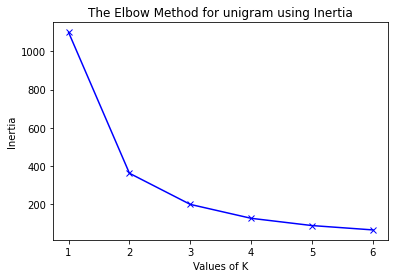

<Figure size 432x288 with 0 Axes>

In [58]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method for unigram using Inertia')
plt.show()
plt.savefig('Elbow_Unigram_Kmeans.png')

## The plot below shows clearly that optimal number of clusters for k-means is 2.

silhouette scores:
2 : 0.618
3 : 0.571
4 : 0.539
5 : 0.526
6 : 0.520
maximum silhouette score for 2 clusters:  0.618


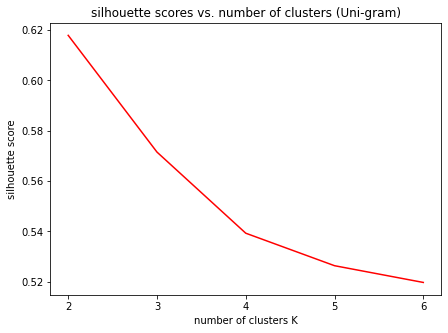

In [59]:
# Only for tri_gram try to calculate silhuette index
from sklearn.metrics import silhouette_score

sil_scores = [silhouette_score(
                                X_unigram, 
                                KMeans(n_clusters=k, random_state=10). \
                                fit_predict(X_unigram)) \
                                for k in range(2,7)]

dict_sil = dict(zip(range(2,7), sil_scores))
print("silhouette scores:")
_ = [print(k, ":", f'{v:,.3f}') for k,v in dict_sil.items()]
K_sil_a3 = max(dict_sil, key=dict_sil.get)            # optimal clusters
sil_opt_a3 = dict_sil[K_sil_a3]                       # optimal silhouette score
print("maximum silhouette score for", f'{K_sil_a3:.0f} clusters: ', f'{sil_opt_a3:.3f}')

plt.figure(figsize=[7,5])
plt.plot(range(2,7), sil_scores, color="red")
plt.title("silhouette scores vs. number of clusters (Uni-gram)")
plt.xticks(np.arange(2,7,1))
plt.xlabel("number of clusters K")
plt.ylabel("silhouette score")
plt.show()

#### Elbow method & Silhuette score: bigram

In [60]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 7)

for k in K:
	# Building and fitting the model
	kmeanModel = KMeans(n_clusters=k).fit(X_bigram)
	kmeanModel.fit(X_bigram)

	distortions.append(sum(np.min(cdist(X_bigram, kmeanModel.cluster_centers_,
										'cosine'), axis=1)) / X_bigram.shape[0])
	inertias.append(kmeanModel.inertia_)

	mapping1[k] = sum(np.min(cdist(X_bigram, kmeanModel.cluster_centers_,
								'cosine'), axis=1)) / X_bigram.shape[0]
	mapping2[k] = kmeanModel.inertia_


In [61]:
for key, val in mapping2.items():
	print(f'{key} : {val}')

1 : 1923.890625
2 : 632.474609375
3 : 368.23565673828125
4 : 237.83291625976562
5 : 171.498046875
6 : 127.81314086914062


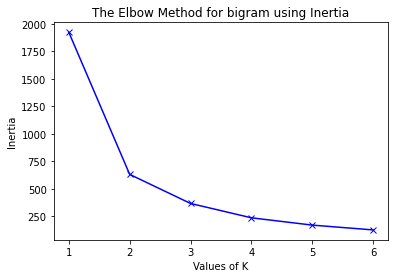

<Figure size 432x288 with 0 Axes>

In [62]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method for bigram using Inertia')
plt.show()
plt.savefig('Elbow_KMeans_bigram.png')

## The plot below shows clearly that optimal number of clusters for k-means is 2.

silhouette scores:
2 : 0.667
3 : 0.562
4 : 0.537
5 : 0.512
6 : 0.507
maximum silhouette score for 2 clusters:  0.667


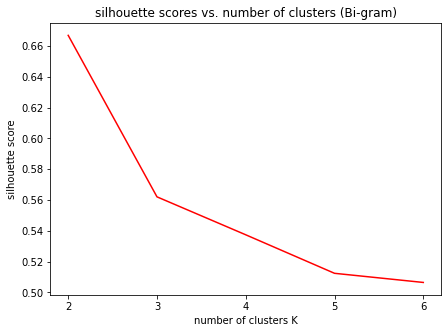

In [63]:
# Only for tri_gram try to calculate silhuette index
from sklearn.metrics import silhouette_score

sil_scores = [silhouette_score(
                                X_bigram, 
                                KMeans(n_clusters=k, random_state=10). \
                                fit_predict(X_bigram)) \
                                for k in range(2,7)]

dict_sil = dict(zip(range(2,7), sil_scores))
print("silhouette scores:")
_ = [print(k, ":", f'{v:,.3f}') for k,v in dict_sil.items()]
K_sil_a3 = max(dict_sil, key=dict_sil.get)            # optimal clusters
sil_opt_a3 = dict_sil[K_sil_a3]                       # optimal silhouette score
print("maximum silhouette score for", f'{K_sil_a3:.0f} clusters: ', f'{sil_opt_a3:.3f}')

plt.figure(figsize=[7,5])
plt.plot(range(2,7), sil_scores, color="red")
plt.title("silhouette scores vs. number of clusters (Bi-gram)")
plt.xticks(np.arange(2,7,1))
plt.xlabel("number of clusters K")
plt.ylabel("silhouette score")
plt.show()

#### Elbow method & Silhuette score: trigram

In [64]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 7)

for k in K:
	# Building and fitting the model
	kmeanModel = KMeans(n_clusters=k).fit(X_trigram)
	kmeanModel.fit(X_trigram)

	distortions.append(sum(np.min(cdist(X_trigram, kmeanModel.cluster_centers_,
										'cosine'), axis=1)) / X_trigram.shape[0])
	inertias.append(kmeanModel.inertia_)

	mapping1[k] = sum(np.min(cdist(X_trigram, kmeanModel.cluster_centers_,
								'cosine'), axis=1)) / X_trigram.shape[0]
	mapping2[k] = kmeanModel.inertia_


In [65]:
for key, val in mapping2.items():
	print(f'{key} : {val}')

1 : 1770.922607421875
2 : 608.7095336914062
3 : 358.4227600097656
4 : 236.11361694335938
5 : 167.64149475097656
6 : 124.19378662109375


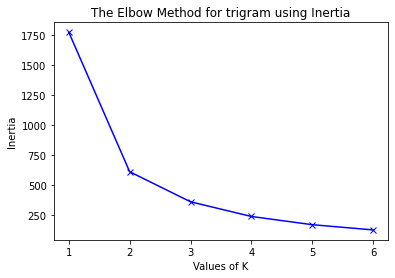

<Figure size 432x288 with 0 Axes>

In [66]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method for trigram using Inertia')
plt.show()
plt.savefig('Elbow_KMeans_trigram.png')

## The plot below doesn't show clearly the optimal number of clusters.

silhouette scores:
2 : 0.671
3 : 0.565
4 : 0.527
5 : 0.504
6 : 0.504
maximum silhouette score for 2 clusters:  0.671


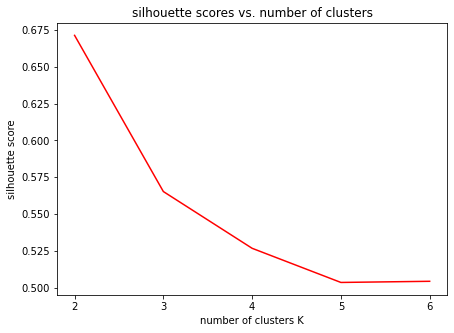

In [67]:
# Only for tri_gram try to calculate silhuette index
from sklearn.metrics import silhouette_score

sil_scores = [silhouette_score(
                                X_trigram, 
                                KMeans(n_clusters=k, random_state=10). \
                                fit_predict(X_trigram)) \
                                for k in range(2,7)]

dict_sil = dict(zip(range(2,7), sil_scores))
print("silhouette scores:")
_ = [print(k, ":", f'{v:,.3f}') for k,v in dict_sil.items()]
K_sil_a3 = max(dict_sil, key=dict_sil.get)            # optimal clusters
sil_opt_a3 = dict_sil[K_sil_a3]                       # optimal silhouette score
print("maximum silhouette score for", f'{K_sil_a3:.0f} clusters: ', f'{sil_opt_a3:.3f}')

plt.figure(figsize=[7,5])
plt.plot(range(2,7), sil_scores, color="red")
plt.title("silhouette scores vs. number of clusters")
plt.xticks(np.arange(2,7,1))
plt.xlabel("number of clusters K")
plt.ylabel("silhouette score")
plt.show()

#### K-means unigram;     n = 3

In [68]:
NUM_CLUSTERS=3
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=5)
labels_pred_unigram = kclusterer.cluster(X_unigram, assign_clusters=True)
print(labels_pred_unigram)

[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 

##### Representation

In [69]:
svd = TruncatedSVD(n_components=2)
data = svd.fit_transform(X_unigram) 
scatter_x_unigram = data[:, 0]
scatter_y_unigram = data[:, 1]

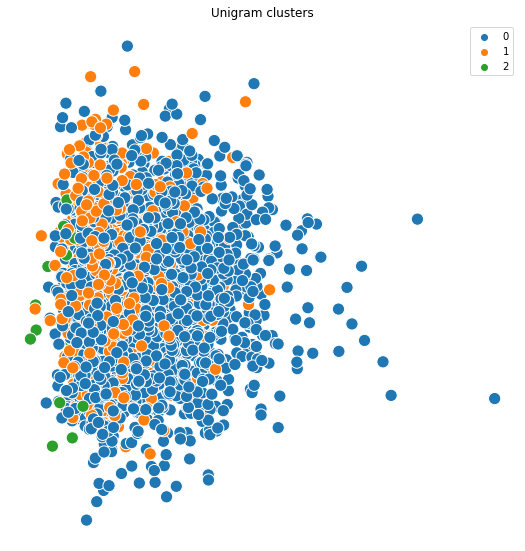

<Figure size 432x288 with 0 Axes>

In [70]:
# visualize cluster
plt.figure(figsize=(8, 8))
plt.title('Unigram clusters')
sns.scatterplot(x = scatter_x_unigram, y = scatter_y_unigram, hue=map(str, labels_pred_unigram), s=150)
plt.tight_layout()
plt.axis('off')
plt.show()
plt.savefig('K-Means Unigram Plot.png')

In [71]:
# Silhuette (vicino a 1 = miglior modello)
sil = metrics.silhouette_score(X_unigram, labels_pred_unigram, metric='cosine')
print('Silhuette index = {:.4f}'.format(sil))

# Davies bouldin (vicino a zero = miglior modello)
from sklearn.metrics import davies_bouldin_score
dav = davies_bouldin_score(X_unigram,labels_pred_unigram)
print('Davies bouldin index = {:.4f}'.format(dav))


Silhuette index = 0.1493
Davies bouldin index = 1.9385


##### Top 10 most frequent words

In [72]:
# Take vocabulary
words = list(w2v_model_unigram.wv.vocab)
# Initialize a dictionary which keys are clusters labels
label_words = {i:{} for i in list(set(labels_pred_unigram))}
for i, word in enumerate(words):  
    # Append words and words count to the right key
    key_value = {word: d_unigram[word]}
    label_words[labels_pred_unigram[i]].update(key_value)


# Sort dictionary descending
c0 = dict(sorted(label_words[0].items(), key=lambda item: item[1], reverse = True))
c1 = dict(sorted(label_words[1].items(), key=lambda item: item[1], reverse = True))
c2 = dict(sorted(label_words[2].items(), key=lambda item: item[1], reverse = True))


# Build a function to extract first n keys-values 
from itertools import islice
def take(n, iterable):
    """Return the first n items of the iterable as a list."""
    return list(islice(iterable, n))

# Take top 10 most frequent words
top_c0 = take(10, c0.items())
top_c1 = take(10, c1.items())
top_c2 = take(10, c2.items())

print('Top 10 most frequent words for cluster 0', top_c0)
print('Top 10 most frequent words for cluster 1', top_c1)
print('Top 10 most frequent words for cluster 2', top_c2)

Top 10 most frequent words for cluster 0 [('bitch', 2140), ('i', 1348), ('hoe', 814), ('is', 525), ('like', 517), ('pussy', 401), ('nigga', 350), ('as', 305), ('get', 301), ('but', 282)]
Top 10 most frequent words for cluster 1 [('one', 147), ('if', 122), ('when', 63), ('way', 61), ('tell', 57), ('always', 51), ('oh', 46), ('lil', 40), ('how', 36), ('wish', 29)]
Top 10 most frequent words for cluster 2 [('yay', 3), ('edge', 3), ('accept', 3), ('putin', 3), ('corny', 3), ('chinese', 3), ('orleans', 2), ('corn', 2), ('morningjoe', 2), ('scandalous', 2)]


#### K-means bigram; n = 3

In [73]:
NUM_CLUSTERS=3
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=5)
labels_pred_bigram = kclusterer.cluster(X_bigram, assign_clusters=True)
print(labels_pred_bigram)

[2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 0, 2, 0, 1, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 0, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 0, 2, 

##### Representation

In [100]:
svd = TruncatedSVD(n_components=2)
data = svd.fit_transform(X_bigram) 
scatter_x = data[:, 0]
scatter_y = data[:, 1]

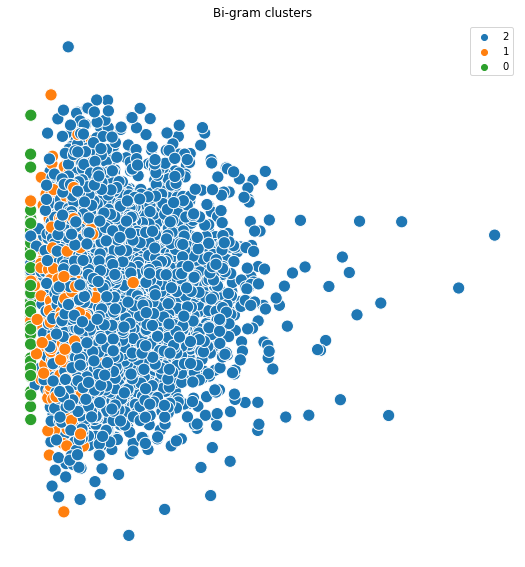

<Figure size 432x288 with 0 Axes>

In [101]:
# visualize cluster
plt.figure(figsize=(8, 8))
sns.scatterplot(x = scatter_x, y = scatter_y, hue=map(str, labels_pred_bigram), s=150)
plt.tight_layout()
plt.axis('off')
plt.title('Bi-gram clusters')
plt.show()
plt.savefig('K-Means_Bigram_Plot.png')


In [76]:
# Silhuette (vicino a 1 = miglior modello)
sil = metrics.silhouette_score(X_bigram, labels_pred_bigram, metric='cosine')
print('Silhuette index = {:.4f}'.format(sil))

# Davies bouldin (vicino a zero = miglior modello)
from sklearn.metrics import davies_bouldin_score
dav = davies_bouldin_score(X_bigram,labels_pred_bigram)
print('Davies Buoldin index = {:.4f}'.format(dav))


Silhuette index = 0.7410
Davies Buoldin index = 0.9504


##### Top 10 most frequent words

In [77]:
# Take vocabulary
words = list(w2v_model_bigram.wv.vocab)
# Initialize a dictionary which keys are clusters labels
label_words_bigram = {i:{} for i in list(set(labels_pred_bigram))}
for i, word in enumerate(words):  
    # Append words and words count to the right key
    key_value = {word: d_bigram[word]}
    label_words_bigram[labels_pred_bigram[i]].update(key_value)


# Sort dictionary descending
c0_bigram = dict(sorted(label_words_bigram[0].items(), key=lambda item: item[1], reverse = True))
c1_bigram = dict(sorted(label_words_bigram[1].items(), key=lambda item: item[1], reverse = True))
c2_bigram = dict(sorted(label_words_bigram[2].items(), key=lambda item: item[1], reverse = True))


# Build a function to extract first n keys-values 
from itertools import islice
def take(n, iterable):
    """Return the first n items of the iterable as a list."""
    return list(islice(iterable, n))

# Take top 10 most frequent words
top_c0_bigram = take(10, c0_bigram.items())
top_c1_bigram = take(10, c1_bigram.items())
top_c2_bigram = take(10, c2_bigram.items())

print('Top 10 most frequent words for cluster 0', top_c0_bigram)
print('Top 10 most frequent words for cluster 1', top_c1_bigram)
print('Top 10 most frequent words for cluster 2', top_c2_bigram)

Top 10 most frequent words for cluster 0 [('trash anyway', 3), ('you pussy', 3), ('whipped cream', 2), ('he yank', 2), ('shy people', 2), ('female trash', 2), ('next door', 2), ('oreo milkshake', 2), ('hat ghetto', 2), ('could get', 2)]
Top 10 most frequent words for cluster 1 [('street', 9), ('uncle om', 7), ('hoe lol', 6), ('when i', 5), ('fucking retard', 5), ('fucking pussy', 5), ('jig', 5), ('ring', 5), ('unfollow', 5), ('tryin', 5)]
Top 10 most frequent words for cluster 2 [('bitch', 2140), ('i', 1348), ('hoe', 814), ('is', 525), ('like', 517), ('pussy', 401), ('nigga', 350), ('as', 305), ('get', 301), ('but', 282)]


#### K-means trigram; n = 3

In [78]:
NUM_CLUSTERS=3
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=5)
labels_pred_trigram = kclusterer.cluster(X_trigram, assign_clusters=True)
print(labels_pred_trigram)

[2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 2, 2, 1, 1, 1, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 0, 0, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 1, 2, 2, 2, 1, 0, 0, 2, 2, 2, 1, 0, 1, 1, 2, 2, 0, 2, 2, 2, 0, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 1, 2, 2, 2, 2, 2, 0, 0, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 

##### Representation

In [79]:
svd = TruncatedSVD(n_components=2)
data = svd.fit_transform(X_trigram) 
scatter_x = data[:, 0]
scatter_y = data[:, 1]

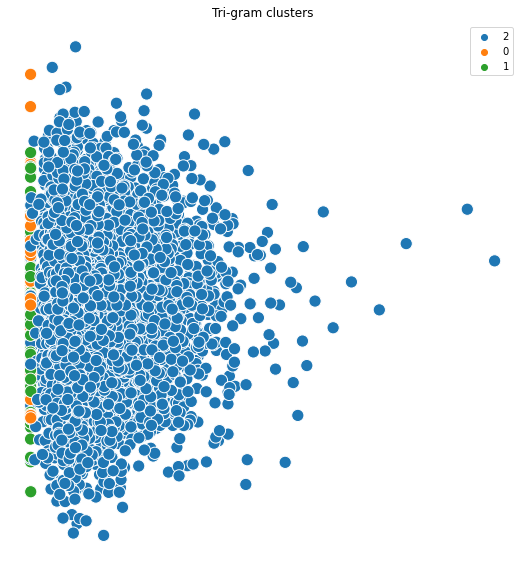

<Figure size 432x288 with 0 Axes>

In [80]:
# visualize cluster
plt.figure(figsize=(8, 8))
sns.scatterplot(x = scatter_x, y = scatter_y, hue=map(str, labels_pred_trigram), s=150)
plt.tight_layout()
plt.title('Tri-gram clusters')
plt.axis('off')
plt.show()
plt.savefig('K-Means Trigram Plot.png')


In [81]:
# Silhuette (vicino a 1 = miglior modello)
sil = metrics.silhouette_score(X_trigram, labels_pred_trigram, metric='cosine')
print('Silhuette index = {:.4f}'.format(sil))

# Davies bouldin (vicino a zero = miglior modello)
from sklearn.metrics import davies_bouldin_score
dav = davies_bouldin_score(X_trigram,labels_pred_trigram)
print('Davies bouldin index = {:.4f}'.format(dav))


Silhuette index = 0.9643
Davies bouldin index = 6.4123


##### Top 10 most frequent words

In [82]:
# Take vocabulary
words = list(w2v_model_trigram.wv.vocab)
# Initialize a dictionary which keys are clusters labels
label_words_trigram = {i:{} for i in list(set(labels_pred_trigram))}
for i, word in enumerate(words):  
    # Append words and words count to the right key
    key_value = {word: d_trigram[word]}
    label_words_trigram[labels_pred_trigram[i]].update(key_value)


# Sort dictionary descending
c0_trigram = dict(sorted(label_words_trigram[0].items(), key=lambda item: item[1], reverse = True))
c1_trigram = dict(sorted(label_words_trigram[1].items(), key=lambda item: item[1], reverse = True))
c2_trigram = dict(sorted(label_words_trigram[2].items(), key=lambda item: item[1], reverse = True))


# Build a function to extract first n keys-values 
from itertools import islice
def take(n, iterable):
    """Return the first n items of the iterable as a list."""
    return list(islice(iterable, n))

# Take top 10 most frequent words
top_c0_trigram = take(10, c0_trigram.items())
top_c1_trigram = take(10, c1_trigram.items())
top_c2_trigram = take(10, c2_trigram.items())

print('Top 10 most frequent words for cluster 0', top_c0_trigram)
print('Top 10 most frequent words for cluster 1', top_c1_trigram)
print('Top 10 most frequent words for cluster 2', top_c2_trigram)

Top 10 most frequent words for cluster 0 [('i feel like', 5), ('new york yankee', 4), ('look like bitch', 4), ('my bitch bad', 4), ('i love hoe', 4), ('hoe like nigga', 3), ('i back bitch', 3), ('i see hoe', 3), ('fuck right pussy', 3), ('bitch i want', 3)]
Top 10 most frequent words for cluster 1 [('hese hoe loyal', 6), ('like little bitch', 5), ('pussy taste like', 5), ('i love bitch', 4), ('i even know', 3), ('act like bitch', 3), ('bitch look good', 3), ('bad bitch she', 3), ('i not bitch', 3), ('i already know', 3)]
Top 10 most frequent words for cluster 2 [('bitch', 2140), ('i', 1348), ('hoe', 814), ('is', 525), ('like', 517), ('pussy', 401), ('nigga', 350), ('as', 305), ('get', 301), ('but', 282)]


### Agglomerative uni_gram; n = 3

In [83]:
completeAgg = AgglomerativeClustering(n_clusters=3, memory=None, connectivity=None, 
                                        compute_full_tree='auto', linkage='ward', distance_threshold=None, compute_distances=False)
CompleteLabelsPred_unigram = completeAgg.fit(X_unigram).labels_

##### Representation

In [84]:
svd = TruncatedSVD(n_components=2)
data = svd.fit_transform(X_unigram) 
scatter_x_unigram = data[:, 0]
scatter_y_unigram = data[:, 1]

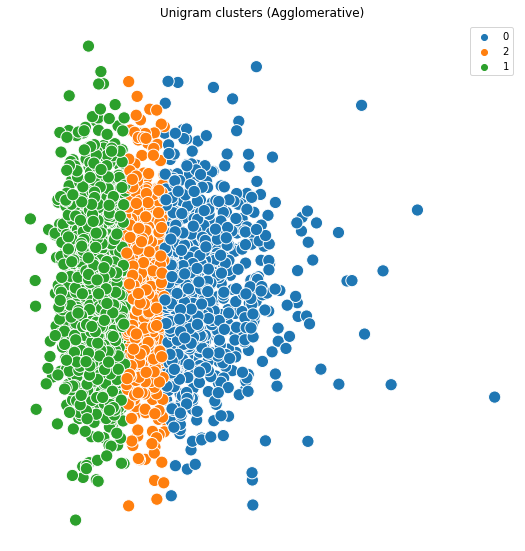

<Figure size 432x288 with 0 Axes>

In [85]:
# visualize cluster
plt.figure(figsize=(8, 8))
plt.title('Unigram clusters (Agglomerative)')
sns.scatterplot(x = scatter_x_unigram, y = scatter_y_unigram, hue=map(str, CompleteLabelsPred_unigram), s=150)
plt.tight_layout()
plt.axis('off')
plt.show()
plt.savefig('Agglomerative Unigram Plot.png')

In [86]:
# Silhuette (vicino a 1 = miglior modello)
sil = metrics.silhouette_score(X_unigram, CompleteLabelsPred_unigram, metric='cosine')
print('Silhuette index = {:.4f}'.format(sil))

# Davies bouldin (vicino a zero = miglior modello)
from sklearn.metrics import davies_bouldin_score
dav = davies_bouldin_score(X_unigram,CompleteLabelsPred_unigram)
print('Davies bouldin index = {:.4f}'.format(dav))

Silhuette index = -0.2386
Davies bouldin index = 0.5804


##### Top 10 most frequent words

In [87]:
# Take vocabulary
words = list(w2v_model_unigram.wv.vocab)
# Initialize a dictionary which keys are clusters labels
Alabel_words = {i:{} for i in list(set(CompleteLabelsPred_unigram))}
for i, word in enumerate(words):  
    # Append words and words count to the right key
    key_value = {word: d_unigram[word]}
    Alabel_words[CompleteLabelsPred_unigram[i]].update(key_value)


# Sort dictionary descending
Ac0 = dict(sorted(Alabel_words[0].items(), key=lambda item: item[1], reverse = True))
Ac1 = dict(sorted(Alabel_words[1].items(), key=lambda item: item[1], reverse = True))
Ac2 = dict(sorted(Alabel_words[2].items(), key=lambda item: item[1], reverse = True))


# Build a function to extract first n keys-values 
from itertools import islice
def take(n, iterable):
    """Return the first n items of the iterable as a list."""
    return list(islice(iterable, n))

# Take top 10 most frequent words
Atop_c0 = take(10, Ac0.items())
Atop_c1 = take(10, Ac1.items())
Atop_c2 = take(10, Ac2.items())

print('Top 10 most frequent words for cluster 0', Atop_c0)
print('Top 10 most frequent words for cluster 1', Atop_c1)
print('Top 10 most frequent words for cluster 2', Atop_c2)

Top 10 most frequent words for cluster 0 [('bitch', 2140), ('i', 1348), ('hoe', 814), ('is', 525), ('like', 517), ('pussy', 401), ('nigga', 350), ('as', 305), ('get', 301), ('but', 282)]
Top 10 most frequent words for cluster 1 [('slap', 11), ('confused', 9), ('jealous', 8), ('sometimes', 7), ('slide', 7), ('alive', 7), ('after', 7), ('peace', 7), ('bullshit', 7), ('neck', 7)]
Top 10 most frequent words for cluster 2 [('watch', 31), ('lmaoo', 28), ('stay', 26), ('dyke', 26), ('who', 25), ('nah', 24), ('wtf', 23), ('your', 22), ('some', 22), ('loyal', 22)]


### Agglomerative bi_gram; n = 3

In [88]:
completeAgg = AgglomerativeClustering(n_clusters=3, memory=None, connectivity=None, 
                                        compute_full_tree='auto', linkage='ward', distance_threshold=None, compute_distances=False)
CompleteLabelsPred_bigram = completeAgg.fit(X_bigram).labels_

##### Representation

In [89]:
svd = TruncatedSVD(n_components=2)
data = svd.fit_transform(X_bigram) 
scatter_x_bigram = data[:, 0]
scatter_y_bigram = data[:, 1]

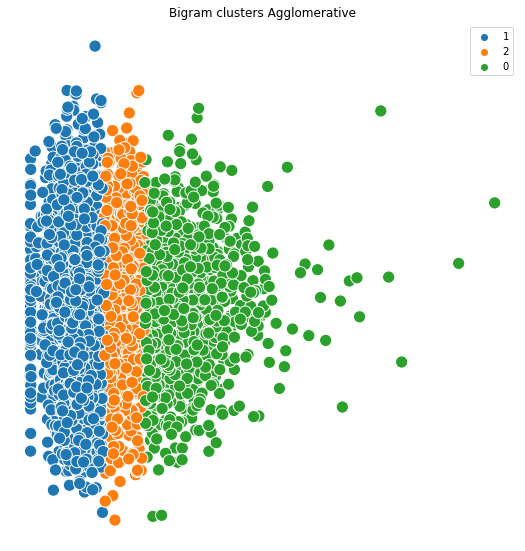

<Figure size 432x288 with 0 Axes>

In [91]:
# visualize cluster
plt.figure(figsize=(8, 8))
plt.title('Bigram clusters Agglomerative')
sns.scatterplot(x = scatter_x_bigram, y = scatter_y_bigram, hue=map(str, CompleteLabelsPred_bigram), s=150)
plt.tight_layout()
plt.axis('off')
plt.show()
plt.savefig('Agglomerative Bigram Plot.png')


In [92]:
# Silhuette (vicino a 1 = miglior modello)
sil = metrics.silhouette_score(X_bigram, CompleteLabelsPred_bigram, metric='cosine')
print('Silhuette index = {:.4f}'.format(sil))

# Davies bouldin (vicino a zero = miglior modello)
from sklearn.metrics import davies_bouldin_score
dav = davies_bouldin_score(X_bigram,CompleteLabelsPred_bigram)
print('Davies bouldin index = {:.4f}'.format(dav))

Silhuette index = -0.5871
Davies bouldin index = 0.5619


##### Top 10 most frequent words

In [93]:
# Take vocabulary
words = list(w2v_model_bigram.wv.vocab)
# Initialize a dictionary which keys are clusters labels
Alabel_words_bigram = {i:{} for i in list(set(CompleteLabelsPred_bigram))}
for i, word in enumerate(words):  
    # Append words and words count to the right key
    key_value = {word: d_bigram[word]}
    Alabel_words_bigram[CompleteLabelsPred_bigram[i]].update(key_value)


# Sort dictionary descending
Ac0_bigram = dict(sorted(Alabel_words_bigram[0].items(), key=lambda item: item[1], reverse = True))
Ac1_bigram = dict(sorted(Alabel_words_bigram[1].items(), key=lambda item: item[1], reverse = True))
Ac2_bigram = dict(sorted(Alabel_words_bigram[2].items(), key=lambda item: item[1], reverse = True))


# Build a function to extract first n keys-values 
from itertools import islice
def take(n, iterable):
    """Return the first n items of the iterable as a list."""
    return list(islice(iterable, n))

# Take top 10 most frequent words
Atop_c0_bigram = take(10, Ac0_bigram.items())
Atop_c1_bigram = take(10, Ac1_bigram.items())
Atop_c2_bigram = take(10, Ac2_bigram.items())

print('Top 10 most frequent words for cluster 0', Atop_c0_bigram)
print('Top 10 most frequent words for cluster 1', Atop_c1_bigram)
print('Top 10 most frequent words for cluster 2', Atop_c2_bigram)

Top 10 most frequent words for cluster 0 [('bitch', 2140), ('i', 1348), ('hoe', 814), ('is', 525), ('like', 517), ('pussy', 401), ('nigga', 350), ('as', 305), ('get', 301), ('but', 282)]
Top 10 most frequent words for cluster 1 [('hoe loyal', 12), ('happy birthday', 10), ('love bitch', 8), ('charlie sheen', 7), ('fucking retarded', 7), ('let hoe', 7), ('yeah bitch', 7), ('slide', 7), ('trash talk', 6), ('i done', 6)]
Top 10 most frequent words for cluster 2 [('fuck bitch', 33), ('yeah', 33), ('is trash', 26), ('text', 25), ('i need', 22), ('some', 22), ('loyal', 22), ('fake', 21), ('ion', 20), ('bitch lol', 19)]


### Agglomerative tri_gram

In [94]:
completeAgg = AgglomerativeClustering(n_clusters=3, memory=None, connectivity=None, 
                                        compute_full_tree='auto', linkage='ward', distance_threshold=None, compute_distances=False)
CompleteLabelsPred_trigram = completeAgg.fit(X_trigram).labels_

##### Representation

In [95]:
svd = TruncatedSVD(n_components=2)
data = svd.fit_transform(X_trigram) 
scatter_x_trigram = data[:, 0]
scatter_y_trigram = data[:, 1]

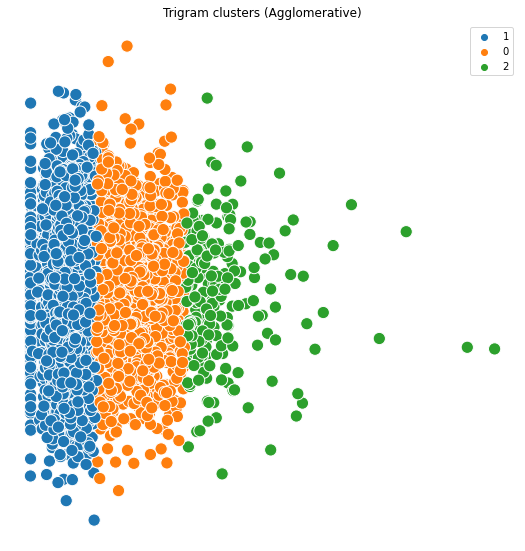

<Figure size 432x288 with 0 Axes>

In [96]:
# visualize cluster
plt.figure(figsize=(8, 8))
plt.title('Trigram clusters (Agglomerative)')
sns.scatterplot(x = scatter_x_trigram, y = scatter_y_trigram, hue=map(str, CompleteLabelsPred_trigram), s=150)
plt.tight_layout()
plt.axis('off')
plt.show()
plt.savefig('Agglomerative Trigram Plot.png')

In [97]:
# Silhuette (vicino a 1 = miglior modello)
sil = metrics.silhouette_score(X_trigram, CompleteLabelsPred_trigram, metric='cosine')
print('Silhuette index = {:.4f}'.format(sil))

# Davies bouldin (vicino a zero = miglior modello)
from sklearn.metrics import davies_bouldin_score
dav = davies_bouldin_score(X_trigram,CompleteLabelsPred_trigram)
print('Davies bouldin index = {:.4f}'.format(dav))

Silhuette index = -0.7337
Davies bouldin index = 0.5490


##### Top 10 most frequent words

In [98]:
# Take vocabulary
words = list(w2v_model_trigram.wv.vocab)
# Initialize a dictionary which keys are clusters labels
Alabel_words_trigram = {i:{} for i in list(set(CompleteLabelsPred_trigram))}
for i, word in enumerate(words):  
    # Append words and words count to the right key
    key_value = {word: d_trigram[word]}
    Alabel_words_trigram[CompleteLabelsPred_trigram[i]].update(key_value)


# Sort dictionary descending
Ac0_trigram = dict(sorted(Alabel_words_trigram[0].items(), key=lambda item: item[1], reverse = True))
Ac1_trigram = dict(sorted(Alabel_words_trigram[1].items(), key=lambda item: item[1], reverse = True))
Ac2_trigram = dict(sorted(Alabel_words_trigram[2].items(), key=lambda item: item[1], reverse = True))


# Build a function to extract first n keys-values 
from itertools import islice
def take(n, iterable):
    """Return the first n items of the iterable as a list."""
    return list(islice(iterable, n))

# Take top 10 most frequent words
Atop_c0_trigram = take(10, Ac0_trigram.items())
Atop_c1_trigram = take(10, Ac1_trigram.items())
Atop_c2_trigram = take(10, Ac2_trigram.items())

print('Top 10 most frequent words for cluster 0', Atop_c0_trigram)
print('Top 10 most frequent words for cluster 1', Atop_c1_trigram)
print('Top 10 most frequent words for cluster 2', Atop_c2_trigram)

Top 10 most frequent words for cluster 0 [('love', 139), ('money', 67), ('fag', 67), ('fuckin', 66), ('when', 63), ('ugly', 61), ('look like', 60), ('hese', 60), ('dumb', 59), ('thing', 56)]
Top 10 most frequent words for cluster 1 [('bitch lol', 19), ('hoe loyal', 12), ('happy birthday', 10), ('i hate bitch', 9), ('i know bitch', 9), ('yo hoe', 9), ('some bitch', 9), ('hoe as nigga', 8), ('flappy bird', 8), ('love bitch', 8)]
Top 10 most frequent words for cluster 2 [('bitch', 2140), ('i', 1348), ('hoe', 814), ('is', 525), ('like', 517), ('pussy', 401), ('nigga', 350), ('as', 305), ('get', 301), ('but', 282)]
